In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_recall_curve, precision_score, recall_score, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten, SimpleRNN, ReLU
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from bokeh.plotting import figure, show, output_file, output_notebook
output_notebook()
%matplotlib inline

Loading BokehJS ...

### Dados
- são carregados os dados pre-procesados no notebook: <i>Data pre-processing</i>

In [2]:
datos = pd.read_csv("./data/all_counts_9_norm_rpkm_log2_preprocessed.csv", index_col=0)
datos.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,5.542667,5.876225,5.189101,6.178741,6.258982,5.921482,6.565341,6.308676,6.256590
aaeB,5.627977,5.436188,5.397088,5.493631,5.603751,5.716862,5.840627,6.132819,5.896502
aaeR,5.645506,5.758852,5.107190,5.824890,5.487705,6.033795,5.710782,6.302440,16.270368
aaeX,6.081770,6.043589,6.030808,6.358792,15.682419,6.129392,6.042647,6.134309,15.797839
aas,6.224669,6.297153,6.297008,6.047021,6.038410,6.296795,6.295251,6.598525,6.568365


### Divisão dos dados para o treinamento da rede GAN
- para o treinamento da rede GAN só serão necessários os genes conhecidos na literatura como genes de referência.

- Do artigo https://biodatamining.biomedcentral.com/articles/10.1186/s13040-017-0150-8 são selecionados 6 genes de referência: cysG, hcaT, idnT, rrsA, ihfB, ssrA. Sendo que o gene idnT não é tomado em conta ja que é um outliers com base nos demais genes.
- Do artigo https://link.springer.com/article/10.1007/s10482-015-0524-1 são selecionados 8 genes os quais estão validados em dois ou mais estudos: gyrA, recA, rpoB, rpoA, gyrB, rho, ftsZ, secA. Também são selecionados 7 genes que são validados uma o só testados em estudos: rpoC, gmk, adk, rpoD, dnaG, glnA, recF.

In [3]:
obj_rg = open("./data/reference_genes.txt")
rg = obj_rg.read().splitlines()
rg.remove("idnT")
print("quantidade de genes de referência:", len(rg))
print(rg)

quantidade de genes de referência: 20
['cysG', 'hcaT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


### Preparação dos dados de treinamento
- Os dados de treinamento são levados a um intervalo de [-1,1], devido a que a função de activação da rede genradora é tanh

In [4]:
X_rg = datos.loc[rg]
X_rg

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964
gyrA,19.364537,19.544602,10.195372,19.601927,19.576949,18.693722,17.988391,16.700954,17.802523
recA,16.741059,16.808839,17.125494,11.214665,10.997956,10.271486,19.879175,18.190008,19.661178
rpoB,8.974988,19.071784,10.029701,19.552264,19.479836,18.539912,8.439041,16.884159,18.085799
rpoA,12.169900,12.425077,13.123721,12.536993,12.467720,11.604108,11.477677,19.684894,11.166540


In [5]:
class scaler:
    def __init__(self, xmin, xmax):
        """
        minmax scaler from dataframe
        """
        self.xmin = xmin
        self.xmax = xmax
        self.min_data = False
        self.max_data = False
        self.flag = False
        
    def fit(self, X):
        self.min_data = np.min(X).values
        self.max_data = np.max(X).values
        self.flag = True
        
    def transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler"
        X_r = X.copy()
        X_r = ((X_r - self.min_data)/(self.max_data - self.min_data))*(self.xmax-self.xmin) + self.xmin
        return X_r
    
    def inverse_transform(self, X):
        assert self.flag, "Erro de treinamento, primeiro tem que treinar o Scaler"
        X_r = X.copy()
        X_r = ((X_r - self.xmin)*(self.max_data - self.min_data)/(self.xmax - self.xmin)) + self.min_data
        return X_r
    

In [6]:
np.min(X_rg)

BB9     5.692781
BB10    5.733848
BB17    5.686571
BB19    5.735536
BB20    6.016590
BB21    6.131968
BB11    6.113390
BB12    5.891730
BB18    5.822536
dtype: float64

In [7]:
obj = scaler(-1,1)
obj.fit(X_rg)
X_train = obj.transform(X_rg)
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669


In [8]:
X_cand = datos.drop(rg)
X_cand.shape

(4168, 9)

In [9]:
X_cand = obj.transform(X_cand)
X_cand.shape

(4168, 9)

### Construção da rede GAN
- Duas redes são feitas para a implementação da rede, uma chamada geradora e a outra discriminadora

In [90]:
class Generator():
    def __init__(self, noise_input, out_dim, optimizerG):
        self.noise_input = noise_input
        self.out_dim = out_dim
        self.optimizerG = optimizerG
        
    def generator(self):
        """
        noise_input: vector con los datos de la distribuición inicial
        out_dim: dimension de la salida esperada, por ejemplo si es una imagen
                 en escala de gris, sería out_dim: (32,32,1)
        Retorna el modelo Generador
        """
        model = Sequential()
        model.add(Dense(50, input_shape=(self.noise_input,)))
        model.add(Dense(150))
        model.add(Dropout(.1))
        model.add(Dense(np.prod(self.out_dim), activation="tanh"))
        model.add(Reshape(self.out_dim))
        return model
    
    def compileG(self):
        Gr = self.generator()
        Gr.compile(loss="binary_crossentropy", optimizer= self.optimizerG)
        return Gr

In [91]:
class Discriminator():
    
    def __init__(self, input_dim, optimizerD):
        self.input_dim = input_dim
        self.optimizerD = optimizerD
    
    def discriminator(self):
        """
        input_dim: dimension de los datos de entrada,
                   por ejemplo si es una imagen en escala de gris,
                   sería input_dim: (32,32,1)
        """
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_dim))
        model.add(LeakyReLU(alpha=.2)) #función rectificadora
        model.add(Dense(32))
        #model.add(LeakyReLU(alpha=.1)) #función rectificadora
        #activación sigmoid ya que se precisa establecer si es 0 ó 1.
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    def compileD(self):
        Dr = self.discriminator()
        Dr.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return Dr

In [92]:
def Gan(generator, discriminator):
    """
    recibe como parámetros de entrada las redes
    generador y discriminador
    """
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False #no se actualizan los pesos
    model.add(discriminator)
    return model

In [93]:
def get_batches(X_train, batch_size):
    """
    X_train: dataset para o treino
    epochs: quantidade de epocas para o treino do gradiente
    batch: tamanho to batch pra o treino de cada epochs
    """
    batches = []
    num_bat = int(np.ceil(X_train.shape[0]/batch_size))
    lim_i = 0
    lim_s = batch_size
    for i in range(num_bat):
        if lim_s > X_train.shape[0]:
            lim_s = X_train.shape[0]
        batches.append(X_train[lim_i:lim_s])
        lim_i += batch_size
        lim_s += batch_size
    return batches

In [94]:
#treinamento da GAN
def train(X_train, epochs, batch_size, G, D, gan, noise_input, verbose=True):
    g_loss = []
    d_loss = []
    precision = []
    recall = []
    kl_d = []
    for epoch in range(epochs):
        batches = get_batches(X_train, batch_size)
        count_b = 0
        t_i = time()
        d_bacth_loss = []
        g_bacth_loss = []
        for batch in batches:
            gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), noise_input))
            #gerando as imagens fake
            syntetic_data = G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((batch, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                               np.zeros((batch.shape[0], 1))))
            #misturar os dados
            #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
            #treino do discriminador
            d_bacth_loss.append(D.train_on_batch(x_combined_batch, y_combined_batch)[0])
            # train generator
            noise = np.random.normal(0, 1, (2*batch.shape[0], noise_input))
            y_mislabled = np.ones((2*batch.shape[0], 1))
            g_bacth_loss.append(gan.train_on_batch(noise, y_mislabled))
        
        #precision
        X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
        X_comb = np.concatenate((X_train, X_sint))
        y_comb = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_sint.shape[0],1))))
        y_predict = D.predict_classes(X_comb)
        y_proba = D.predict_proba(X_comb)
        kl_d.append(np.mean((1-y_proba)*np.log((1-y_proba)/y_proba)))
        #f1_lag = f1_score(y_test, y_predict)
        precision.append(precision_score(y_comb, y_predict))
        recall.append(recall_score(y_comb, y_predict))
        #fscore.append(f1_lag)
        t_f = time()
        t = t_f - t_i
        t_i = time()

        d_loss.append(d_bacth_loss[-1])
        g_loss.append(g_bacth_loss[-1])
        if verbose:
            print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                   % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))

    return g_loss, d_loss, precision, recall, kl_d

In [106]:
noise_input = 50
ep = 3000
#Gerador
optimizerG = SGD(lr=0.00015, momentum=0.92, decay=0.00015/ep)
#optimizerG = SGD(lr=0.00011, momentum=0.92)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/ep)
#optimizerD = SGD(lr=0.001, momentum=0.9)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()
gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  50
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_33 (Sequential)   (None, 9)                 11559     
_________________________________________________________________
sequential_34 (Sequential)   (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


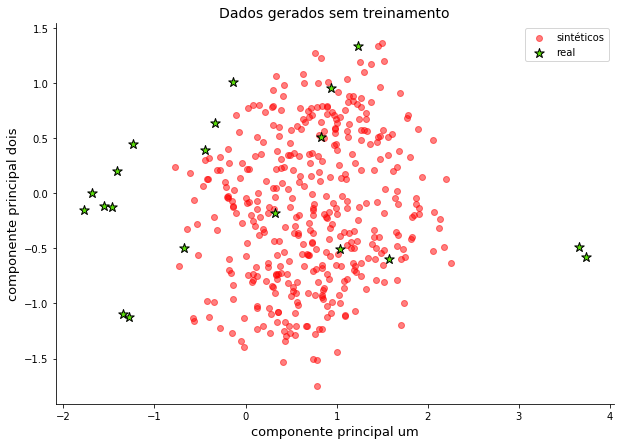

In [107]:
pca_real = PCA(n_components=2)
X_train_pca = pca_real.fit_transform(X_train)

noise = np.random.normal(0, 1, size=(X_train.shape[0]*20, noise_input))
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.title("Dados gerados sem treinamento", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
x_noise = G.predict(noise)
X_sint_pca = pca_real.transform(x_noise)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintéticos", alpha=.5)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [108]:
g_loss, d_loss, precision, recall, kld = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D,
                                          gan=gan, noise_input=noise_input)

epoch:[1/3000] [Discriminator::d_loss: 0.707573],[Generator::loss: 0.678396], 3.336691[sec]
epoch:[2/3000] [Discriminator::d_loss: 0.748268],[Generator::loss: 0.624009], 0.015605[sec]
epoch:[3/3000] [Discriminator::d_loss: 0.704203],[Generator::loss: 0.621882], 0.016505[sec]
epoch:[4/3000] [Discriminator::d_loss: 0.749198],[Generator::loss: 0.649046], 0.019068[sec]
epoch:[5/3000] [Discriminator::d_loss: 0.729247],[Generator::loss: 0.649544], 0.015663[sec]
epoch:[6/3000] [Discriminator::d_loss: 0.715385],[Generator::loss: 0.681660], 0.016471[sec]
epoch:[7/3000] [Discriminator::d_loss: 0.699660],[Generator::loss: 0.669874], 0.019132[sec]
epoch:[8/3000] [Discriminator::d_loss: 0.725413],[Generator::loss: 0.669291], 0.015348[sec]
epoch:[9/3000] [Discriminator::d_loss: 0.704832],[Generator::loss: 0.652246], 0.016600[sec]
epoch:[10/3000] [Discriminator::d_loss: 0.741910],[Generator::loss: 0.680556], 0.015445[sec]
epoch:[11/3000] [Discriminator::d_loss: 0.758422],[Generator::loss: 0.625126], 

epoch:[100/3000] [Discriminator::d_loss: 0.641927],[Generator::loss: 0.769008], 0.017369[sec]
epoch:[101/3000] [Discriminator::d_loss: 0.621152],[Generator::loss: 0.717231], 0.024875[sec]
epoch:[102/3000] [Discriminator::d_loss: 0.613140],[Generator::loss: 0.647254], 0.021676[sec]
epoch:[103/3000] [Discriminator::d_loss: 0.652148],[Generator::loss: 0.683038], 0.017350[sec]
epoch:[104/3000] [Discriminator::d_loss: 0.603633],[Generator::loss: 0.722566], 0.016943[sec]
epoch:[105/3000] [Discriminator::d_loss: 0.654201],[Generator::loss: 0.734841], 0.017360[sec]
epoch:[106/3000] [Discriminator::d_loss: 0.632474],[Generator::loss: 0.755596], 0.027331[sec]
epoch:[107/3000] [Discriminator::d_loss: 0.650612],[Generator::loss: 0.732262], 0.023267[sec]
epoch:[108/3000] [Discriminator::d_loss: 0.663269],[Generator::loss: 0.710633], 0.024127[sec]
epoch:[109/3000] [Discriminator::d_loss: 0.637456],[Generator::loss: 0.706038], 0.029372[sec]
epoch:[110/3000] [Discriminator::d_loss: 0.610050],[Generato

epoch:[190/3000] [Discriminator::d_loss: 0.642751],[Generator::loss: 0.792740], 0.022727[sec]
epoch:[191/3000] [Discriminator::d_loss: 0.570086],[Generator::loss: 0.836479], 0.018134[sec]
epoch:[192/3000] [Discriminator::d_loss: 0.602924],[Generator::loss: 0.782409], 0.016143[sec]
epoch:[193/3000] [Discriminator::d_loss: 0.617064],[Generator::loss: 0.819894], 0.016569[sec]
epoch:[194/3000] [Discriminator::d_loss: 0.600313],[Generator::loss: 0.777052], 0.016080[sec]
epoch:[195/3000] [Discriminator::d_loss: 0.563905],[Generator::loss: 0.770148], 0.015229[sec]
epoch:[196/3000] [Discriminator::d_loss: 0.609534],[Generator::loss: 0.759087], 0.015563[sec]
epoch:[197/3000] [Discriminator::d_loss: 0.577996],[Generator::loss: 0.770791], 0.015260[sec]
epoch:[198/3000] [Discriminator::d_loss: 0.571773],[Generator::loss: 0.874097], 0.016640[sec]
epoch:[199/3000] [Discriminator::d_loss: 0.616448],[Generator::loss: 0.750407], 0.016623[sec]
epoch:[200/3000] [Discriminator::d_loss: 0.605045],[Generato

epoch:[283/3000] [Discriminator::d_loss: 0.607353],[Generator::loss: 0.877357], 0.018845[sec]
epoch:[284/3000] [Discriminator::d_loss: 0.567428],[Generator::loss: 0.866115], 0.019084[sec]
epoch:[285/3000] [Discriminator::d_loss: 0.560577],[Generator::loss: 0.827501], 0.017402[sec]
epoch:[286/3000] [Discriminator::d_loss: 0.541669],[Generator::loss: 0.850312], 0.016091[sec]
epoch:[287/3000] [Discriminator::d_loss: 0.547153],[Generator::loss: 0.808576], 0.015659[sec]
epoch:[288/3000] [Discriminator::d_loss: 0.588214],[Generator::loss: 0.806763], 0.015779[sec]
epoch:[289/3000] [Discriminator::d_loss: 0.573443],[Generator::loss: 0.857948], 0.015738[sec]
epoch:[290/3000] [Discriminator::d_loss: 0.555091],[Generator::loss: 0.806646], 0.015897[sec]
epoch:[291/3000] [Discriminator::d_loss: 0.580267],[Generator::loss: 0.816761], 0.016365[sec]
epoch:[292/3000] [Discriminator::d_loss: 0.564298],[Generator::loss: 0.871144], 0.016389[sec]
epoch:[293/3000] [Discriminator::d_loss: 0.581794],[Generato

epoch:[373/3000] [Discriminator::d_loss: 0.583993],[Generator::loss: 0.870917], 0.019083[sec]
epoch:[374/3000] [Discriminator::d_loss: 0.551240],[Generator::loss: 0.867568], 0.017404[sec]
epoch:[375/3000] [Discriminator::d_loss: 0.553637],[Generator::loss: 0.859502], 0.018592[sec]
epoch:[376/3000] [Discriminator::d_loss: 0.563060],[Generator::loss: 0.815306], 0.016857[sec]
epoch:[377/3000] [Discriminator::d_loss: 0.553849],[Generator::loss: 0.859288], 0.015496[sec]
epoch:[378/3000] [Discriminator::d_loss: 0.563896],[Generator::loss: 0.889862], 0.015368[sec]
epoch:[379/3000] [Discriminator::d_loss: 0.550713],[Generator::loss: 0.896209], 0.015646[sec]
epoch:[380/3000] [Discriminator::d_loss: 0.548142],[Generator::loss: 0.886792], 0.022720[sec]
epoch:[381/3000] [Discriminator::d_loss: 0.602620],[Generator::loss: 0.849223], 0.020916[sec]
epoch:[382/3000] [Discriminator::d_loss: 0.549459],[Generator::loss: 0.864763], 0.019335[sec]
epoch:[383/3000] [Discriminator::d_loss: 0.549857],[Generato

epoch:[469/3000] [Discriminator::d_loss: 0.553093],[Generator::loss: 0.891176], 0.020844[sec]
epoch:[470/3000] [Discriminator::d_loss: 0.544649],[Generator::loss: 0.873179], 0.017900[sec]
epoch:[471/3000] [Discriminator::d_loss: 0.560202],[Generator::loss: 0.884573], 0.017385[sec]
epoch:[472/3000] [Discriminator::d_loss: 0.541056],[Generator::loss: 0.911310], 0.015842[sec]
epoch:[473/3000] [Discriminator::d_loss: 0.505938],[Generator::loss: 0.872623], 0.015831[sec]
epoch:[474/3000] [Discriminator::d_loss: 0.527880],[Generator::loss: 0.854181], 0.016101[sec]
epoch:[475/3000] [Discriminator::d_loss: 0.551010],[Generator::loss: 0.928473], 0.019155[sec]
epoch:[476/3000] [Discriminator::d_loss: 0.533111],[Generator::loss: 0.895449], 0.017862[sec]
epoch:[477/3000] [Discriminator::d_loss: 0.543510],[Generator::loss: 0.874624], 0.016760[sec]
epoch:[478/3000] [Discriminator::d_loss: 0.563571],[Generator::loss: 0.868183], 0.016494[sec]
epoch:[479/3000] [Discriminator::d_loss: 0.540845],[Generato

epoch:[564/3000] [Discriminator::d_loss: 0.539795],[Generator::loss: 1.008610], 0.019239[sec]
epoch:[565/3000] [Discriminator::d_loss: 0.549877],[Generator::loss: 1.002600], 0.021152[sec]
epoch:[566/3000] [Discriminator::d_loss: 0.523273],[Generator::loss: 0.876301], 0.017654[sec]
epoch:[567/3000] [Discriminator::d_loss: 0.562510],[Generator::loss: 0.909729], 0.015535[sec]
epoch:[568/3000] [Discriminator::d_loss: 0.523854],[Generator::loss: 0.912350], 0.015966[sec]
epoch:[569/3000] [Discriminator::d_loss: 0.535861],[Generator::loss: 0.850527], 0.016454[sec]
epoch:[570/3000] [Discriminator::d_loss: 0.534462],[Generator::loss: 0.895002], 0.015911[sec]
epoch:[571/3000] [Discriminator::d_loss: 0.551907],[Generator::loss: 0.886913], 0.018398[sec]
epoch:[572/3000] [Discriminator::d_loss: 0.511149],[Generator::loss: 0.904341], 0.015782[sec]
epoch:[573/3000] [Discriminator::d_loss: 0.546194],[Generator::loss: 0.939829], 0.015785[sec]
epoch:[574/3000] [Discriminator::d_loss: 0.556799],[Generato

epoch:[656/3000] [Discriminator::d_loss: 0.569796],[Generator::loss: 0.937861], 0.017186[sec]
epoch:[657/3000] [Discriminator::d_loss: 0.611910],[Generator::loss: 0.912553], 0.026136[sec]
epoch:[658/3000] [Discriminator::d_loss: 0.547942],[Generator::loss: 0.898170], 0.017095[sec]
epoch:[659/3000] [Discriminator::d_loss: 0.579204],[Generator::loss: 0.954402], 0.016774[sec]
epoch:[660/3000] [Discriminator::d_loss: 0.592235],[Generator::loss: 0.920416], 0.016089[sec]
epoch:[661/3000] [Discriminator::d_loss: 0.532410],[Generator::loss: 0.938301], 0.016263[sec]
epoch:[662/3000] [Discriminator::d_loss: 0.564001],[Generator::loss: 0.847329], 0.016181[sec]
epoch:[663/3000] [Discriminator::d_loss: 0.517183],[Generator::loss: 0.933572], 0.017834[sec]
epoch:[664/3000] [Discriminator::d_loss: 0.554354],[Generator::loss: 0.919149], 0.016121[sec]
epoch:[665/3000] [Discriminator::d_loss: 0.579169],[Generator::loss: 0.878658], 0.015892[sec]
epoch:[666/3000] [Discriminator::d_loss: 0.557817],[Generato

epoch:[749/3000] [Discriminator::d_loss: 0.551916],[Generator::loss: 0.875591], 0.018314[sec]
epoch:[750/3000] [Discriminator::d_loss: 0.606373],[Generator::loss: 0.916203], 0.024689[sec]
epoch:[751/3000] [Discriminator::d_loss: 0.648616],[Generator::loss: 0.879623], 0.018074[sec]
epoch:[752/3000] [Discriminator::d_loss: 0.573785],[Generator::loss: 0.824958], 0.016482[sec]
epoch:[753/3000] [Discriminator::d_loss: 0.601190],[Generator::loss: 0.813043], 0.015816[sec]
epoch:[754/3000] [Discriminator::d_loss: 0.567964],[Generator::loss: 0.882299], 0.015875[sec]
epoch:[755/3000] [Discriminator::d_loss: 0.609139],[Generator::loss: 0.851321], 0.015724[sec]
epoch:[756/3000] [Discriminator::d_loss: 0.649089],[Generator::loss: 0.886951], 0.015972[sec]
epoch:[757/3000] [Discriminator::d_loss: 0.591978],[Generator::loss: 0.895357], 0.016060[sec]
epoch:[758/3000] [Discriminator::d_loss: 0.642567],[Generator::loss: 0.850265], 0.016975[sec]
epoch:[759/3000] [Discriminator::d_loss: 0.614349],[Generato

epoch:[839/3000] [Discriminator::d_loss: 0.643050],[Generator::loss: 0.912040], 0.020667[sec]
epoch:[840/3000] [Discriminator::d_loss: 0.612414],[Generator::loss: 0.851727], 0.025558[sec]
epoch:[841/3000] [Discriminator::d_loss: 0.633831],[Generator::loss: 0.880673], 0.019468[sec]
epoch:[842/3000] [Discriminator::d_loss: 0.612037],[Generator::loss: 0.829564], 0.017527[sec]
epoch:[843/3000] [Discriminator::d_loss: 0.633399],[Generator::loss: 0.911356], 0.018202[sec]
epoch:[844/3000] [Discriminator::d_loss: 0.668846],[Generator::loss: 0.827140], 0.020199[sec]
epoch:[845/3000] [Discriminator::d_loss: 0.665285],[Generator::loss: 0.893030], 0.017242[sec]
epoch:[846/3000] [Discriminator::d_loss: 0.622932],[Generator::loss: 0.902974], 0.017639[sec]
epoch:[847/3000] [Discriminator::d_loss: 0.636132],[Generator::loss: 0.963327], 0.018855[sec]
epoch:[848/3000] [Discriminator::d_loss: 0.637153],[Generator::loss: 0.839302], 0.019320[sec]
epoch:[849/3000] [Discriminator::d_loss: 0.609367],[Generato

epoch:[933/3000] [Discriminator::d_loss: 0.610871],[Generator::loss: 0.810778], 0.017785[sec]
epoch:[934/3000] [Discriminator::d_loss: 0.718036],[Generator::loss: 0.927718], 0.020946[sec]
epoch:[935/3000] [Discriminator::d_loss: 0.661615],[Generator::loss: 0.856081], 0.016808[sec]
epoch:[936/3000] [Discriminator::d_loss: 0.683043],[Generator::loss: 0.865739], 0.016100[sec]
epoch:[937/3000] [Discriminator::d_loss: 0.620537],[Generator::loss: 0.862548], 0.016208[sec]
epoch:[938/3000] [Discriminator::d_loss: 0.668919],[Generator::loss: 0.775343], 0.016112[sec]
epoch:[939/3000] [Discriminator::d_loss: 0.608243],[Generator::loss: 0.921562], 0.016810[sec]
epoch:[940/3000] [Discriminator::d_loss: 0.636355],[Generator::loss: 0.835910], 0.016867[sec]
epoch:[941/3000] [Discriminator::d_loss: 0.655638],[Generator::loss: 0.892876], 0.016390[sec]
epoch:[942/3000] [Discriminator::d_loss: 0.653023],[Generator::loss: 0.775146], 0.016027[sec]
epoch:[943/3000] [Discriminator::d_loss: 0.632676],[Generato

epoch:[1028/3000] [Discriminator::d_loss: 0.659247],[Generator::loss: 0.824832], 0.018392[sec]
epoch:[1029/3000] [Discriminator::d_loss: 0.717936],[Generator::loss: 0.877116], 0.018009[sec]
epoch:[1030/3000] [Discriminator::d_loss: 0.647109],[Generator::loss: 0.867681], 0.016204[sec]
epoch:[1031/3000] [Discriminator::d_loss: 0.722000],[Generator::loss: 0.797022], 0.015399[sec]
epoch:[1032/3000] [Discriminator::d_loss: 0.658250],[Generator::loss: 0.848555], 0.015128[sec]
epoch:[1033/3000] [Discriminator::d_loss: 0.644312],[Generator::loss: 0.829901], 0.015455[sec]
epoch:[1034/3000] [Discriminator::d_loss: 0.647308],[Generator::loss: 0.849532], 0.015399[sec]
epoch:[1035/3000] [Discriminator::d_loss: 0.686603],[Generator::loss: 0.821269], 0.015413[sec]
epoch:[1036/3000] [Discriminator::d_loss: 0.653849],[Generator::loss: 0.896501], 0.017377[sec]
epoch:[1037/3000] [Discriminator::d_loss: 0.682175],[Generator::loss: 0.901495], 0.015544[sec]
epoch:[1038/3000] [Discriminator::d_loss: 0.701802

epoch:[1123/3000] [Discriminator::d_loss: 0.681360],[Generator::loss: 0.820236], 0.019434[sec]
epoch:[1124/3000] [Discriminator::d_loss: 0.676515],[Generator::loss: 0.832801], 0.019323[sec]
epoch:[1125/3000] [Discriminator::d_loss: 0.663452],[Generator::loss: 0.840051], 0.016085[sec]
epoch:[1126/3000] [Discriminator::d_loss: 0.688153],[Generator::loss: 0.811144], 0.015385[sec]
epoch:[1127/3000] [Discriminator::d_loss: 0.677346],[Generator::loss: 0.868655], 0.015309[sec]
epoch:[1128/3000] [Discriminator::d_loss: 0.688822],[Generator::loss: 0.837260], 0.015945[sec]
epoch:[1129/3000] [Discriminator::d_loss: 0.717210],[Generator::loss: 0.863233], 0.015323[sec]
epoch:[1130/3000] [Discriminator::d_loss: 0.682263],[Generator::loss: 0.787882], 0.016466[sec]
epoch:[1131/3000] [Discriminator::d_loss: 0.694334],[Generator::loss: 0.884464], 0.015993[sec]
epoch:[1132/3000] [Discriminator::d_loss: 0.625347],[Generator::loss: 0.859985], 0.015463[sec]
epoch:[1133/3000] [Discriminator::d_loss: 0.694436

epoch:[1210/3000] [Discriminator::d_loss: 0.707609],[Generator::loss: 0.830449], 0.019712[sec]
epoch:[1211/3000] [Discriminator::d_loss: 0.704906],[Generator::loss: 0.799449], 0.017843[sec]
epoch:[1212/3000] [Discriminator::d_loss: 0.712780],[Generator::loss: 0.790642], 0.015648[sec]
epoch:[1213/3000] [Discriminator::d_loss: 0.676149],[Generator::loss: 0.850019], 0.017667[sec]
epoch:[1214/3000] [Discriminator::d_loss: 0.722174],[Generator::loss: 0.789407], 0.016865[sec]
epoch:[1215/3000] [Discriminator::d_loss: 0.649685],[Generator::loss: 0.813737], 0.015371[sec]
epoch:[1216/3000] [Discriminator::d_loss: 0.743124],[Generator::loss: 0.824595], 0.015601[sec]
epoch:[1217/3000] [Discriminator::d_loss: 0.673627],[Generator::loss: 0.716249], 0.015266[sec]
epoch:[1218/3000] [Discriminator::d_loss: 0.671287],[Generator::loss: 0.855848], 0.015455[sec]
epoch:[1219/3000] [Discriminator::d_loss: 0.693350],[Generator::loss: 0.839125], 0.016587[sec]
epoch:[1220/3000] [Discriminator::d_loss: 0.681206

epoch:[1301/3000] [Discriminator::d_loss: 0.719792],[Generator::loss: 0.771772], 0.017519[sec]
epoch:[1302/3000] [Discriminator::d_loss: 0.689070],[Generator::loss: 0.825231], 0.018286[sec]
epoch:[1303/3000] [Discriminator::d_loss: 0.712185],[Generator::loss: 0.786402], 0.016197[sec]
epoch:[1304/3000] [Discriminator::d_loss: 0.711109],[Generator::loss: 0.791465], 0.017075[sec]
epoch:[1305/3000] [Discriminator::d_loss: 0.683596],[Generator::loss: 0.812817], 0.016266[sec]
epoch:[1306/3000] [Discriminator::d_loss: 0.673008],[Generator::loss: 0.815166], 0.015284[sec]
epoch:[1307/3000] [Discriminator::d_loss: 0.693901],[Generator::loss: 0.800140], 0.015389[sec]
epoch:[1308/3000] [Discriminator::d_loss: 0.677064],[Generator::loss: 0.794544], 0.015337[sec]
epoch:[1309/3000] [Discriminator::d_loss: 0.728717],[Generator::loss: 0.793748], 0.015194[sec]
epoch:[1310/3000] [Discriminator::d_loss: 0.713898],[Generator::loss: 0.809583], 0.015111[sec]
epoch:[1311/3000] [Discriminator::d_loss: 0.741148

epoch:[1391/3000] [Discriminator::d_loss: 0.670647],[Generator::loss: 0.768313], 0.019397[sec]
epoch:[1392/3000] [Discriminator::d_loss: 0.699428],[Generator::loss: 0.825266], 0.018173[sec]
epoch:[1393/3000] [Discriminator::d_loss: 0.711421],[Generator::loss: 0.822796], 0.015837[sec]
epoch:[1394/3000] [Discriminator::d_loss: 0.672105],[Generator::loss: 0.733296], 0.017316[sec]
epoch:[1395/3000] [Discriminator::d_loss: 0.673853],[Generator::loss: 0.738598], 0.015571[sec]
epoch:[1396/3000] [Discriminator::d_loss: 0.687219],[Generator::loss: 0.736804], 0.015260[sec]
epoch:[1397/3000] [Discriminator::d_loss: 0.667231],[Generator::loss: 0.774751], 0.015190[sec]
epoch:[1398/3000] [Discriminator::d_loss: 0.689335],[Generator::loss: 0.792250], 0.015245[sec]
epoch:[1399/3000] [Discriminator::d_loss: 0.657209],[Generator::loss: 0.795818], 0.015206[sec]
epoch:[1400/3000] [Discriminator::d_loss: 0.696637],[Generator::loss: 0.721962], 0.018539[sec]
epoch:[1401/3000] [Discriminator::d_loss: 0.712199

epoch:[1482/3000] [Discriminator::d_loss: 0.691595],[Generator::loss: 0.782251], 0.017991[sec]
epoch:[1483/3000] [Discriminator::d_loss: 0.678554],[Generator::loss: 0.818266], 0.017628[sec]
epoch:[1484/3000] [Discriminator::d_loss: 0.693377],[Generator::loss: 0.831170], 0.015995[sec]
epoch:[1485/3000] [Discriminator::d_loss: 0.704698],[Generator::loss: 0.742366], 0.015194[sec]
epoch:[1486/3000] [Discriminator::d_loss: 0.704726],[Generator::loss: 0.829204], 0.017469[sec]
epoch:[1487/3000] [Discriminator::d_loss: 0.676691],[Generator::loss: 0.752569], 0.016247[sec]
epoch:[1488/3000] [Discriminator::d_loss: 0.701520],[Generator::loss: 0.763306], 0.015505[sec]
epoch:[1489/3000] [Discriminator::d_loss: 0.665271],[Generator::loss: 0.751136], 0.015257[sec]
epoch:[1490/3000] [Discriminator::d_loss: 0.678956],[Generator::loss: 0.842414], 0.015167[sec]
epoch:[1491/3000] [Discriminator::d_loss: 0.697429],[Generator::loss: 0.839731], 0.015431[sec]
epoch:[1492/3000] [Discriminator::d_loss: 0.627758

epoch:[1572/3000] [Discriminator::d_loss: 0.697532],[Generator::loss: 0.792351], 0.017608[sec]
epoch:[1573/3000] [Discriminator::d_loss: 0.673128],[Generator::loss: 0.782691], 0.016955[sec]
epoch:[1574/3000] [Discriminator::d_loss: 0.678650],[Generator::loss: 0.779703], 0.015996[sec]
epoch:[1575/3000] [Discriminator::d_loss: 0.674129],[Generator::loss: 0.814135], 0.016604[sec]
epoch:[1576/3000] [Discriminator::d_loss: 0.685884],[Generator::loss: 0.784692], 0.016726[sec]
epoch:[1577/3000] [Discriminator::d_loss: 0.696086],[Generator::loss: 0.796798], 0.016376[sec]
epoch:[1578/3000] [Discriminator::d_loss: 0.680888],[Generator::loss: 0.832777], 0.015526[sec]
epoch:[1579/3000] [Discriminator::d_loss: 0.683378],[Generator::loss: 0.816952], 0.015387[sec]
epoch:[1580/3000] [Discriminator::d_loss: 0.688083],[Generator::loss: 0.815282], 0.015441[sec]
epoch:[1581/3000] [Discriminator::d_loss: 0.689038],[Generator::loss: 0.820981], 0.015613[sec]
epoch:[1582/3000] [Discriminator::d_loss: 0.686272

epoch:[1668/3000] [Discriminator::d_loss: 0.670088],[Generator::loss: 0.767053], 0.020065[sec]
epoch:[1669/3000] [Discriminator::d_loss: 0.717553],[Generator::loss: 0.792984], 0.019631[sec]
epoch:[1670/3000] [Discriminator::d_loss: 0.678723],[Generator::loss: 0.789092], 0.016479[sec]
epoch:[1671/3000] [Discriminator::d_loss: 0.688790],[Generator::loss: 0.786413], 0.016577[sec]
epoch:[1672/3000] [Discriminator::d_loss: 0.690082],[Generator::loss: 0.784880], 0.019647[sec]
epoch:[1673/3000] [Discriminator::d_loss: 0.721271],[Generator::loss: 0.764017], 0.015438[sec]
epoch:[1674/3000] [Discriminator::d_loss: 0.685503],[Generator::loss: 0.751350], 0.016752[sec]
epoch:[1675/3000] [Discriminator::d_loss: 0.671066],[Generator::loss: 0.774101], 0.015993[sec]
epoch:[1676/3000] [Discriminator::d_loss: 0.686791],[Generator::loss: 0.791277], 0.015885[sec]
epoch:[1677/3000] [Discriminator::d_loss: 0.681235],[Generator::loss: 0.802867], 0.015870[sec]
epoch:[1678/3000] [Discriminator::d_loss: 0.679629

epoch:[1756/3000] [Discriminator::d_loss: 0.695690],[Generator::loss: 0.772715], 0.018186[sec]
epoch:[1757/3000] [Discriminator::d_loss: 0.677035],[Generator::loss: 0.771674], 0.018737[sec]
epoch:[1758/3000] [Discriminator::d_loss: 0.675481],[Generator::loss: 0.753450], 0.016308[sec]
epoch:[1759/3000] [Discriminator::d_loss: 0.665453],[Generator::loss: 0.759354], 0.015560[sec]
epoch:[1760/3000] [Discriminator::d_loss: 0.696424],[Generator::loss: 0.785355], 0.015798[sec]
epoch:[1761/3000] [Discriminator::d_loss: 0.673748],[Generator::loss: 0.774849], 0.015563[sec]
epoch:[1762/3000] [Discriminator::d_loss: 0.707791],[Generator::loss: 0.751823], 0.015688[sec]
epoch:[1763/3000] [Discriminator::d_loss: 0.661582],[Generator::loss: 0.742256], 0.015486[sec]
epoch:[1764/3000] [Discriminator::d_loss: 0.678039],[Generator::loss: 0.750835], 0.016800[sec]
epoch:[1765/3000] [Discriminator::d_loss: 0.673782],[Generator::loss: 0.743187], 0.015875[sec]
epoch:[1766/3000] [Discriminator::d_loss: 0.665347

epoch:[1845/3000] [Discriminator::d_loss: 0.684594],[Generator::loss: 0.773545], 0.033853[sec]
epoch:[1846/3000] [Discriminator::d_loss: 0.685811],[Generator::loss: 0.756655], 0.037850[sec]
epoch:[1847/3000] [Discriminator::d_loss: 0.687107],[Generator::loss: 0.760755], 0.031528[sec]
epoch:[1848/3000] [Discriminator::d_loss: 0.680347],[Generator::loss: 0.784377], 0.030722[sec]
epoch:[1849/3000] [Discriminator::d_loss: 0.676896],[Generator::loss: 0.767497], 0.020237[sec]
epoch:[1850/3000] [Discriminator::d_loss: 0.677196],[Generator::loss: 0.784350], 0.019094[sec]
epoch:[1851/3000] [Discriminator::d_loss: 0.675521],[Generator::loss: 0.757576], 0.022112[sec]
epoch:[1852/3000] [Discriminator::d_loss: 0.679895],[Generator::loss: 0.772171], 0.022995[sec]
epoch:[1853/3000] [Discriminator::d_loss: 0.671886],[Generator::loss: 0.827259], 0.021957[sec]
epoch:[1854/3000] [Discriminator::d_loss: 0.682206],[Generator::loss: 0.780164], 0.019364[sec]
epoch:[1855/3000] [Discriminator::d_loss: 0.693139

epoch:[1934/3000] [Discriminator::d_loss: 0.684590],[Generator::loss: 0.752361], 0.016397[sec]
epoch:[1935/3000] [Discriminator::d_loss: 0.666795],[Generator::loss: 0.741189], 0.022482[sec]
epoch:[1936/3000] [Discriminator::d_loss: 0.682669],[Generator::loss: 0.775303], 0.016392[sec]
epoch:[1937/3000] [Discriminator::d_loss: 0.684677],[Generator::loss: 0.766954], 0.017298[sec]
epoch:[1938/3000] [Discriminator::d_loss: 0.688773],[Generator::loss: 0.750593], 0.017047[sec]
epoch:[1939/3000] [Discriminator::d_loss: 0.688927],[Generator::loss: 0.736482], 0.015700[sec]
epoch:[1940/3000] [Discriminator::d_loss: 0.706099],[Generator::loss: 0.767019], 0.015426[sec]
epoch:[1941/3000] [Discriminator::d_loss: 0.698300],[Generator::loss: 0.718661], 0.015782[sec]
epoch:[1942/3000] [Discriminator::d_loss: 0.688328],[Generator::loss: 0.748536], 0.015927[sec]
epoch:[1943/3000] [Discriminator::d_loss: 0.691616],[Generator::loss: 0.733762], 0.016489[sec]
epoch:[1944/3000] [Discriminator::d_loss: 0.705394

epoch:[2029/3000] [Discriminator::d_loss: 0.679330],[Generator::loss: 0.740604], 0.018069[sec]
epoch:[2030/3000] [Discriminator::d_loss: 0.680935],[Generator::loss: 0.759121], 0.018623[sec]
epoch:[2031/3000] [Discriminator::d_loss: 0.686038],[Generator::loss: 0.777891], 0.016138[sec]
epoch:[2032/3000] [Discriminator::d_loss: 0.694936],[Generator::loss: 0.738550], 0.015994[sec]
epoch:[2033/3000] [Discriminator::d_loss: 0.657265],[Generator::loss: 0.733989], 0.016654[sec]
epoch:[2034/3000] [Discriminator::d_loss: 0.676265],[Generator::loss: 0.734936], 0.016018[sec]
epoch:[2035/3000] [Discriminator::d_loss: 0.682080],[Generator::loss: 0.738467], 0.015924[sec]
epoch:[2036/3000] [Discriminator::d_loss: 0.676455],[Generator::loss: 0.742845], 0.015593[sec]
epoch:[2037/3000] [Discriminator::d_loss: 0.681079],[Generator::loss: 0.714694], 0.015886[sec]
epoch:[2038/3000] [Discriminator::d_loss: 0.680285],[Generator::loss: 0.738722], 0.015315[sec]
epoch:[2039/3000] [Discriminator::d_loss: 0.685388

epoch:[2120/3000] [Discriminator::d_loss: 0.680318],[Generator::loss: 0.748190], 0.017947[sec]
epoch:[2121/3000] [Discriminator::d_loss: 0.687681],[Generator::loss: 0.769284], 0.017548[sec]
epoch:[2122/3000] [Discriminator::d_loss: 0.682110],[Generator::loss: 0.752287], 0.015959[sec]
epoch:[2123/3000] [Discriminator::d_loss: 0.686348],[Generator::loss: 0.755406], 0.016211[sec]
epoch:[2124/3000] [Discriminator::d_loss: 0.687412],[Generator::loss: 0.755464], 0.016685[sec]
epoch:[2125/3000] [Discriminator::d_loss: 0.674090],[Generator::loss: 0.753677], 0.015540[sec]
epoch:[2126/3000] [Discriminator::d_loss: 0.686795],[Generator::loss: 0.761234], 0.015588[sec]
epoch:[2127/3000] [Discriminator::d_loss: 0.685419],[Generator::loss: 0.763386], 0.015788[sec]
epoch:[2128/3000] [Discriminator::d_loss: 0.690205],[Generator::loss: 0.747588], 0.015660[sec]
epoch:[2129/3000] [Discriminator::d_loss: 0.665831],[Generator::loss: 0.729632], 0.015576[sec]
epoch:[2130/3000] [Discriminator::d_loss: 0.675909

epoch:[2211/3000] [Discriminator::d_loss: 0.681184],[Generator::loss: 0.760865], 0.020561[sec]
epoch:[2212/3000] [Discriminator::d_loss: 0.688118],[Generator::loss: 0.729812], 0.017121[sec]
epoch:[2213/3000] [Discriminator::d_loss: 0.671244],[Generator::loss: 0.742264], 0.016886[sec]
epoch:[2214/3000] [Discriminator::d_loss: 0.682169],[Generator::loss: 0.752662], 0.017961[sec]
epoch:[2215/3000] [Discriminator::d_loss: 0.680044],[Generator::loss: 0.757178], 0.015688[sec]
epoch:[2216/3000] [Discriminator::d_loss: 0.683831],[Generator::loss: 0.733644], 0.015513[sec]
epoch:[2217/3000] [Discriminator::d_loss: 0.675477],[Generator::loss: 0.755231], 0.015651[sec]
epoch:[2218/3000] [Discriminator::d_loss: 0.682613],[Generator::loss: 0.738552], 0.015781[sec]
epoch:[2219/3000] [Discriminator::d_loss: 0.677399],[Generator::loss: 0.729183], 0.015679[sec]
epoch:[2220/3000] [Discriminator::d_loss: 0.682212],[Generator::loss: 0.751328], 0.017978[sec]
epoch:[2221/3000] [Discriminator::d_loss: 0.703329

epoch:[2301/3000] [Discriminator::d_loss: 0.672530],[Generator::loss: 0.748571], 0.017648[sec]
epoch:[2302/3000] [Discriminator::d_loss: 0.665064],[Generator::loss: 0.745423], 0.017299[sec]
epoch:[2303/3000] [Discriminator::d_loss: 0.664484],[Generator::loss: 0.706796], 0.017288[sec]
epoch:[2304/3000] [Discriminator::d_loss: 0.679407],[Generator::loss: 0.734874], 0.016886[sec]
epoch:[2305/3000] [Discriminator::d_loss: 0.661484],[Generator::loss: 0.728973], 0.015886[sec]
epoch:[2306/3000] [Discriminator::d_loss: 0.671432],[Generator::loss: 0.724705], 0.015484[sec]
epoch:[2307/3000] [Discriminator::d_loss: 0.671429],[Generator::loss: 0.745270], 0.015875[sec]
epoch:[2308/3000] [Discriminator::d_loss: 0.675847],[Generator::loss: 0.732458], 0.015620[sec]
epoch:[2309/3000] [Discriminator::d_loss: 0.681162],[Generator::loss: 0.715674], 0.019353[sec]
epoch:[2310/3000] [Discriminator::d_loss: 0.672306],[Generator::loss: 0.742861], 0.015386[sec]
epoch:[2311/3000] [Discriminator::d_loss: 0.669426

epoch:[2391/3000] [Discriminator::d_loss: 0.683614],[Generator::loss: 0.752181], 0.017957[sec]
epoch:[2392/3000] [Discriminator::d_loss: 0.685202],[Generator::loss: 0.758464], 0.021652[sec]
epoch:[2393/3000] [Discriminator::d_loss: 0.678504],[Generator::loss: 0.759501], 0.021049[sec]
epoch:[2394/3000] [Discriminator::d_loss: 0.675664],[Generator::loss: 0.730445], 0.018163[sec]
epoch:[2395/3000] [Discriminator::d_loss: 0.680465],[Generator::loss: 0.742098], 0.016740[sec]
epoch:[2396/3000] [Discriminator::d_loss: 0.672293],[Generator::loss: 0.753183], 0.017310[sec]
epoch:[2397/3000] [Discriminator::d_loss: 0.673404],[Generator::loss: 0.733301], 0.017195[sec]
epoch:[2398/3000] [Discriminator::d_loss: 0.683924],[Generator::loss: 0.738696], 0.020531[sec]
epoch:[2399/3000] [Discriminator::d_loss: 0.673697],[Generator::loss: 0.732784], 0.017079[sec]
epoch:[2400/3000] [Discriminator::d_loss: 0.673692],[Generator::loss: 0.734111], 0.015911[sec]
epoch:[2401/3000] [Discriminator::d_loss: 0.665854

epoch:[2484/3000] [Discriminator::d_loss: 0.659961],[Generator::loss: 0.752538], 0.028470[sec]
epoch:[2485/3000] [Discriminator::d_loss: 0.668869],[Generator::loss: 0.762731], 0.018391[sec]
epoch:[2486/3000] [Discriminator::d_loss: 0.683826],[Generator::loss: 0.756375], 0.020312[sec]
epoch:[2487/3000] [Discriminator::d_loss: 0.659594],[Generator::loss: 0.739024], 0.019802[sec]
epoch:[2488/3000] [Discriminator::d_loss: 0.659890],[Generator::loss: 0.767226], 0.018987[sec]
epoch:[2489/3000] [Discriminator::d_loss: 0.669259],[Generator::loss: 0.746250], 0.017837[sec]
epoch:[2490/3000] [Discriminator::d_loss: 0.682057],[Generator::loss: 0.778022], 0.018658[sec]
epoch:[2491/3000] [Discriminator::d_loss: 0.661806],[Generator::loss: 0.766829], 0.018513[sec]
epoch:[2492/3000] [Discriminator::d_loss: 0.659894],[Generator::loss: 0.738138], 0.016786[sec]
epoch:[2493/3000] [Discriminator::d_loss: 0.668455],[Generator::loss: 0.744178], 0.016249[sec]
epoch:[2494/3000] [Discriminator::d_loss: 0.670725

epoch:[2575/3000] [Discriminator::d_loss: 0.679865],[Generator::loss: 0.729855], 0.018861[sec]
epoch:[2576/3000] [Discriminator::d_loss: 0.665215],[Generator::loss: 0.771516], 0.026835[sec]
epoch:[2577/3000] [Discriminator::d_loss: 0.676955],[Generator::loss: 0.771248], 0.020769[sec]
epoch:[2578/3000] [Discriminator::d_loss: 0.668206],[Generator::loss: 0.743824], 0.021949[sec]
epoch:[2579/3000] [Discriminator::d_loss: 0.663188],[Generator::loss: 0.759587], 0.018326[sec]
epoch:[2580/3000] [Discriminator::d_loss: 0.678842],[Generator::loss: 0.726961], 0.015929[sec]
epoch:[2581/3000] [Discriminator::d_loss: 0.681063],[Generator::loss: 0.730903], 0.015918[sec]
epoch:[2582/3000] [Discriminator::d_loss: 0.678197],[Generator::loss: 0.739208], 0.017320[sec]
epoch:[2583/3000] [Discriminator::d_loss: 0.670328],[Generator::loss: 0.770432], 0.016406[sec]
epoch:[2584/3000] [Discriminator::d_loss: 0.678748],[Generator::loss: 0.751456], 0.015699[sec]
epoch:[2585/3000] [Discriminator::d_loss: 0.677354

epoch:[2667/3000] [Discriminator::d_loss: 0.665466],[Generator::loss: 0.749814], 0.016396[sec]
epoch:[2668/3000] [Discriminator::d_loss: 0.666041],[Generator::loss: 0.726293], 0.020923[sec]
epoch:[2669/3000] [Discriminator::d_loss: 0.675373],[Generator::loss: 0.720996], 0.020527[sec]
epoch:[2670/3000] [Discriminator::d_loss: 0.662233],[Generator::loss: 0.763715], 0.026607[sec]
epoch:[2671/3000] [Discriminator::d_loss: 0.670516],[Generator::loss: 0.777859], 0.023739[sec]
epoch:[2672/3000] [Discriminator::d_loss: 0.667548],[Generator::loss: 0.735901], 0.021359[sec]
epoch:[2673/3000] [Discriminator::d_loss: 0.686174],[Generator::loss: 0.742230], 0.017437[sec]
epoch:[2674/3000] [Discriminator::d_loss: 0.669172],[Generator::loss: 0.751395], 0.017526[sec]
epoch:[2675/3000] [Discriminator::d_loss: 0.669121],[Generator::loss: 0.755390], 0.017911[sec]
epoch:[2676/3000] [Discriminator::d_loss: 0.667953],[Generator::loss: 0.751462], 0.023392[sec]
epoch:[2677/3000] [Discriminator::d_loss: 0.670338

epoch:[2759/3000] [Discriminator::d_loss: 0.665604],[Generator::loss: 0.705902], 0.017466[sec]
epoch:[2760/3000] [Discriminator::d_loss: 0.673696],[Generator::loss: 0.698729], 0.025501[sec]
epoch:[2761/3000] [Discriminator::d_loss: 0.670999],[Generator::loss: 0.737319], 0.017521[sec]
epoch:[2762/3000] [Discriminator::d_loss: 0.660396],[Generator::loss: 0.752820], 0.018622[sec]
epoch:[2763/3000] [Discriminator::d_loss: 0.692764],[Generator::loss: 0.744362], 0.023196[sec]
epoch:[2764/3000] [Discriminator::d_loss: 0.660431],[Generator::loss: 0.704409], 0.024155[sec]
epoch:[2765/3000] [Discriminator::d_loss: 0.666365],[Generator::loss: 0.737510], 0.023173[sec]
epoch:[2766/3000] [Discriminator::d_loss: 0.676686],[Generator::loss: 0.714325], 0.020491[sec]
epoch:[2767/3000] [Discriminator::d_loss: 0.657227],[Generator::loss: 0.783056], 0.017767[sec]
epoch:[2768/3000] [Discriminator::d_loss: 0.664796],[Generator::loss: 0.724557], 0.020518[sec]
epoch:[2769/3000] [Discriminator::d_loss: 0.686435

epoch:[2852/3000] [Discriminator::d_loss: 0.695106],[Generator::loss: 0.759028], 0.018885[sec]
epoch:[2853/3000] [Discriminator::d_loss: 0.681270],[Generator::loss: 0.753155], 0.020149[sec]
epoch:[2854/3000] [Discriminator::d_loss: 0.680983],[Generator::loss: 0.734769], 0.017172[sec]
epoch:[2855/3000] [Discriminator::d_loss: 0.676847],[Generator::loss: 0.723677], 0.019343[sec]
epoch:[2856/3000] [Discriminator::d_loss: 0.671032],[Generator::loss: 0.746500], 0.021357[sec]
epoch:[2857/3000] [Discriminator::d_loss: 0.673528],[Generator::loss: 0.751899], 0.018290[sec]
epoch:[2858/3000] [Discriminator::d_loss: 0.676185],[Generator::loss: 0.774028], 0.019672[sec]
epoch:[2859/3000] [Discriminator::d_loss: 0.680543],[Generator::loss: 0.724753], 0.016922[sec]
epoch:[2860/3000] [Discriminator::d_loss: 0.682760],[Generator::loss: 0.722749], 0.018343[sec]
epoch:[2861/3000] [Discriminator::d_loss: 0.677353],[Generator::loss: 0.697623], 0.017373[sec]
epoch:[2862/3000] [Discriminator::d_loss: 0.666938

epoch:[2946/3000] [Discriminator::d_loss: 0.661254],[Generator::loss: 0.741937], 0.018154[sec]
epoch:[2947/3000] [Discriminator::d_loss: 0.689943],[Generator::loss: 0.724237], 0.018658[sec]
epoch:[2948/3000] [Discriminator::d_loss: 0.696254],[Generator::loss: 0.698408], 0.016946[sec]
epoch:[2949/3000] [Discriminator::d_loss: 0.679957],[Generator::loss: 0.739316], 0.015727[sec]
epoch:[2950/3000] [Discriminator::d_loss: 0.672449],[Generator::loss: 0.714314], 0.015065[sec]
epoch:[2951/3000] [Discriminator::d_loss: 0.671014],[Generator::loss: 0.735331], 0.015393[sec]
epoch:[2952/3000] [Discriminator::d_loss: 0.663694],[Generator::loss: 0.747679], 0.016185[sec]
epoch:[2953/3000] [Discriminator::d_loss: 0.677806],[Generator::loss: 0.713312], 0.016302[sec]
epoch:[2954/3000] [Discriminator::d_loss: 0.681956],[Generator::loss: 0.733206], 0.015199[sec]
epoch:[2955/3000] [Discriminator::d_loss: 0.657030],[Generator::loss: 0.747454], 0.015392[sec]
epoch:[2956/3000] [Discriminator::d_loss: 0.687211

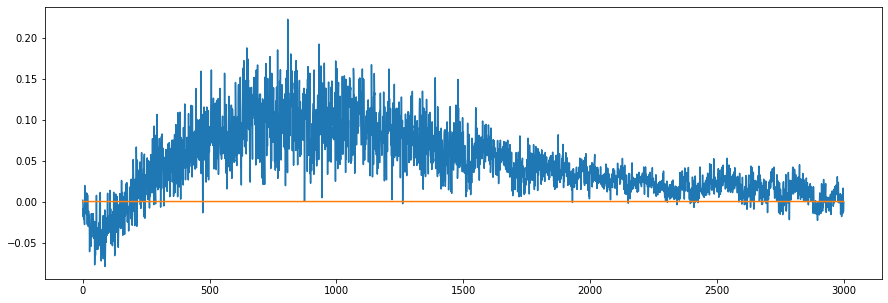

In [109]:
plt.figure(figsize=(15,5))
plt.plot(range(len(kld)), kld)
plt.plot(range(len(kld)), np.ones(len(kld))*0);

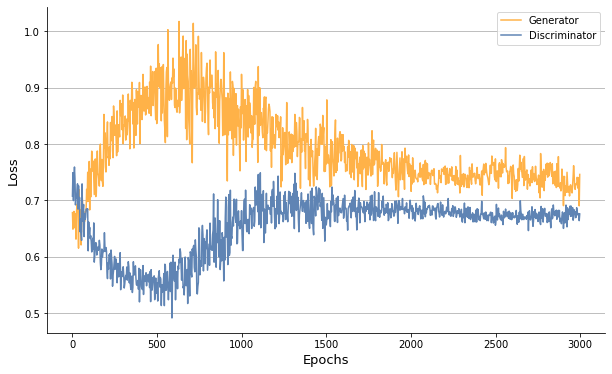

In [110]:
fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
rr = range(0,len(precision), 3)
short_precision = [precision[i] for i in rr]
short_g_loss = [g_loss[i] for i in rr]
short_d_loss = [d_loss[i] for i in rr]
#plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(rr, short_g_loss, label="Generator", color="#FFB248")
plt.plot(rr, short_d_loss, label="Discriminator", color="#5F84B4")
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.grid(axis="y")
plt.legend();

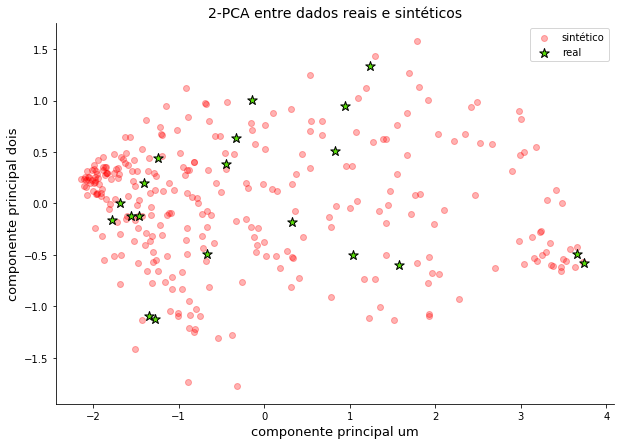

In [111]:
X_sint = G.predict(np.random.normal(0, 1, (300, noise_input)))
X_nov = np.concatenate((X_train[:14], X_sint))

fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

X_sint_pca = pca_real.transform(X_sint)

plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [112]:

from sklearn.svm import OneClassSVM
#nu=0.0112

clf = OneClassSVM(kernel="rbf", nu=0.01, gamma=1/X_nov.shape[1], max_iter=-1).fit(X_nov) #0.0138

print("train recall score: ", recall_score(np.ones(X_nov.shape[0]), clf.predict(X_nov)))
print("train recall score in the RG: ", recall_score(np.ones(14), clf.predict(X_train[:14])))
print("test recall score in the RG: ", accuracy_score(np.ones(6),clf.predict(X_train[14:]) ))
print("recall em todos os genes de referência: ", accuracy_score(np.ones(X_train.shape[0]),clf.predict(X_train)))
print("------------------------------------------------------")

predict_cand = clf.predict(X_cand)

cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
cand.shape, no_cand.shape

train recall score:  0.9808917197452229
train recall score in the RG:  0.7857142857142857
test recall score in the RG:  0.8333333333333334
recall em todos os genes de referência:  0.8
------------------------------------------------------


((917, 9), (3251, 9))

In [113]:
sc, df = clf.score_samples(X_nov), clf.decision_function(X_nov)


In [114]:
sc[np.where(df<0)], np.where(df<0)

(array([1.13259711, 1.13221715, 1.13275882, 1.13227688, 1.13263273,
        1.13275883]), (array([  6,   7,  10,  78, 158, 233]),))

In [115]:
np.sort(sc)[:len(sc[np.where(df<0)])] == np.sort(sc[np.where(df<0)])

array([ True,  True,  True,  True,  True,  True])

In [117]:
min_pre = np.inf
l_dist = []
for i in range(300):
    t_i = time()
    noise_input = 50
    ep = 1700
    #Gerador
    optimizerG = SGD(lr=0.00015, momentum=0.92, decay=0.00015/ep)
    #optimizerG = SGD(lr=0.00011, momentum=0.92)
    obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
    G = obj_G.compileG()
    # Discriminador
    optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/ep)
    #optimizerD = SGD(lr=0.001, momentum=0.9)
    objD = Discriminator((X_train.shape[1],), optimizerD)
    D = objD.compileD()
    gan = Gan(G,D)
    gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
    w_i = gan.get_weights().copy()
    g_loss, d_loss, precision, recall, _ = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D,
                                          gan=gan, noise_input=noise_input, verbose=False)
    l_pre = []
    for k in range(50):
        X_gen = G.predict(np.random.normal(0, 1, (300, noise_input)))
        y_proba = D.predict_proba(X_gen)
        d = []
        for g in range(X_train.shape[0]):
            d.append(np.mean(abs(X_train.iloc[g,:].values-X_gen)))
        l_pre.append(np.mean(np.array(d)) + np.mean((1-y_proba)*np.log((1-y_proba)/y_proba)))
    l_dist.append(np.mean(np.array(l_pre)))
    if np.mean(np.array(l_pre)) < min_pre:
        min_pre = np.mean(np.array(l_pre))
        w_best = w_i
    t_f = time()
    print("iteração: ",i," ", np.round(t_f-t_i,4), "[s]")

iteração:  0   40.2756 [s]
iteração:  1   35.6382 [s]
iteração:  2   36.9512 [s]
iteração:  3   37.7221 [s]
iteração:  4   38.825 [s]
iteração:  5   43.4459 [s]
iteração:  6   41.2034 [s]


KeyboardInterrupt: 

In [118]:
noise_input = 50
ep = 1700
#Gerador
optimizerG = SGD(lr=0.00015, momentum=0.92, decay=0.00015/ep)
#optimizerG = SGD(lr=0.00011, momentum=0.92)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/ep)
#optimizerD = SGD(lr=0.001, momentum=0.9)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()
gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  50
Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_63 (Sequential)   (None, 9)                 11559     
_________________________________________________________________
sequential_64 (Sequential)   (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


In [119]:
gan.get_weights()[0][0][0]

-0.21924835

In [123]:
gan.set_weights(w_best)
gan.get_weights()[0][0][0]

-0.056016892

In [124]:
g_loss, d_loss, precision, recall, _ = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D,
                                          gan=gan, noise_input=noise_input)

epoch:[1/1700] [Discriminator::d_loss: 0.832933],[Generator::loss: 0.869841], 0.030039[sec]
epoch:[2/1700] [Discriminator::d_loss: 0.837276],[Generator::loss: 0.862435], 0.031574[sec]
epoch:[3/1700] [Discriminator::d_loss: 0.820949],[Generator::loss: 0.738817], 0.029147[sec]
epoch:[4/1700] [Discriminator::d_loss: 0.837234],[Generator::loss: 0.832955], 0.023028[sec]
epoch:[5/1700] [Discriminator::d_loss: 0.838714],[Generator::loss: 0.774004], 0.022121[sec]
epoch:[6/1700] [Discriminator::d_loss: 0.844661],[Generator::loss: 0.823958], 0.026624[sec]
epoch:[7/1700] [Discriminator::d_loss: 0.833097],[Generator::loss: 0.864753], 0.020882[sec]
epoch:[8/1700] [Discriminator::d_loss: 0.836056],[Generator::loss: 0.762465], 0.019243[sec]
epoch:[9/1700] [Discriminator::d_loss: 0.804297],[Generator::loss: 0.838824], 0.019250[sec]
epoch:[10/1700] [Discriminator::d_loss: 0.833256],[Generator::loss: 0.859831], 0.026198[sec]
epoch:[11/1700] [Discriminator::d_loss: 0.815501],[Generator::loss: 0.744446], 

epoch:[94/1700] [Discriminator::d_loss: 0.691920],[Generator::loss: 0.675389], 0.025436[sec]
epoch:[95/1700] [Discriminator::d_loss: 0.639557],[Generator::loss: 0.698198], 0.029203[sec]
epoch:[96/1700] [Discriminator::d_loss: 0.654297],[Generator::loss: 0.669266], 0.029256[sec]
epoch:[97/1700] [Discriminator::d_loss: 0.663563],[Generator::loss: 0.667305], 0.023431[sec]
epoch:[98/1700] [Discriminator::d_loss: 0.633529],[Generator::loss: 0.733455], 0.022373[sec]
epoch:[99/1700] [Discriminator::d_loss: 0.650359],[Generator::loss: 0.714218], 0.019585[sec]
epoch:[100/1700] [Discriminator::d_loss: 0.626030],[Generator::loss: 0.685739], 0.021131[sec]
epoch:[101/1700] [Discriminator::d_loss: 0.637936],[Generator::loss: 0.710711], 0.019247[sec]
epoch:[102/1700] [Discriminator::d_loss: 0.614833],[Generator::loss: 0.720262], 0.018974[sec]
epoch:[103/1700] [Discriminator::d_loss: 0.637956],[Generator::loss: 0.682268], 0.020752[sec]
epoch:[104/1700] [Discriminator::d_loss: 0.657470],[Generator::los

epoch:[183/1700] [Discriminator::d_loss: 0.602424],[Generator::loss: 0.788355], 0.021291[sec]
epoch:[184/1700] [Discriminator::d_loss: 0.599130],[Generator::loss: 0.752536], 0.025877[sec]
epoch:[185/1700] [Discriminator::d_loss: 0.582366],[Generator::loss: 0.780975], 0.020546[sec]
epoch:[186/1700] [Discriminator::d_loss: 0.585403],[Generator::loss: 0.770999], 0.019642[sec]
epoch:[187/1700] [Discriminator::d_loss: 0.636717],[Generator::loss: 0.757243], 0.029484[sec]
epoch:[188/1700] [Discriminator::d_loss: 0.634902],[Generator::loss: 0.699451], 0.030313[sec]
epoch:[189/1700] [Discriminator::d_loss: 0.633561],[Generator::loss: 0.717069], 0.030835[sec]
epoch:[190/1700] [Discriminator::d_loss: 0.604887],[Generator::loss: 0.762159], 0.033964[sec]
epoch:[191/1700] [Discriminator::d_loss: 0.592773],[Generator::loss: 0.790946], 0.035466[sec]
epoch:[192/1700] [Discriminator::d_loss: 0.594592],[Generator::loss: 0.740434], 0.027490[sec]
epoch:[193/1700] [Discriminator::d_loss: 0.582781],[Generato

epoch:[280/1700] [Discriminator::d_loss: 0.601453],[Generator::loss: 0.772849], 0.019496[sec]
epoch:[281/1700] [Discriminator::d_loss: 0.576382],[Generator::loss: 0.865773], 0.023341[sec]
epoch:[282/1700] [Discriminator::d_loss: 0.551121],[Generator::loss: 0.849062], 0.020321[sec]
epoch:[283/1700] [Discriminator::d_loss: 0.583124],[Generator::loss: 0.868800], 0.020066[sec]
epoch:[284/1700] [Discriminator::d_loss: 0.562643],[Generator::loss: 0.816710], 0.019507[sec]
epoch:[285/1700] [Discriminator::d_loss: 0.573342],[Generator::loss: 0.855109], 0.018939[sec]
epoch:[286/1700] [Discriminator::d_loss: 0.555965],[Generator::loss: 0.813761], 0.018917[sec]
epoch:[287/1700] [Discriminator::d_loss: 0.576837],[Generator::loss: 0.875961], 0.019543[sec]
epoch:[288/1700] [Discriminator::d_loss: 0.559464],[Generator::loss: 0.797161], 0.021503[sec]
epoch:[289/1700] [Discriminator::d_loss: 0.578630],[Generator::loss: 0.800477], 0.019120[sec]
epoch:[290/1700] [Discriminator::d_loss: 0.623294],[Generato

epoch:[373/1700] [Discriminator::d_loss: 0.636978],[Generator::loss: 0.839988], 0.019539[sec]
epoch:[374/1700] [Discriminator::d_loss: 0.599331],[Generator::loss: 0.938444], 0.022806[sec]
epoch:[375/1700] [Discriminator::d_loss: 0.606012],[Generator::loss: 0.927207], 0.021342[sec]
epoch:[376/1700] [Discriminator::d_loss: 0.547586],[Generator::loss: 0.882614], 0.019909[sec]
epoch:[377/1700] [Discriminator::d_loss: 0.579954],[Generator::loss: 0.947463], 0.019170[sec]
epoch:[378/1700] [Discriminator::d_loss: 0.565687],[Generator::loss: 0.853164], 0.019043[sec]
epoch:[379/1700] [Discriminator::d_loss: 0.574164],[Generator::loss: 0.822166], 0.019078[sec]
epoch:[380/1700] [Discriminator::d_loss: 0.556776],[Generator::loss: 0.863630], 0.020938[sec]
epoch:[381/1700] [Discriminator::d_loss: 0.583058],[Generator::loss: 0.904929], 0.018923[sec]
epoch:[382/1700] [Discriminator::d_loss: 0.562181],[Generator::loss: 1.013333], 0.019123[sec]
epoch:[383/1700] [Discriminator::d_loss: 0.575893],[Generato

epoch:[464/1700] [Discriminator::d_loss: 0.568341],[Generator::loss: 0.872934], 0.021849[sec]
epoch:[465/1700] [Discriminator::d_loss: 0.528938],[Generator::loss: 0.888018], 0.029464[sec]
epoch:[466/1700] [Discriminator::d_loss: 0.584232],[Generator::loss: 0.961809], 0.020279[sec]
epoch:[467/1700] [Discriminator::d_loss: 0.526551],[Generator::loss: 0.962101], 0.020934[sec]
epoch:[468/1700] [Discriminator::d_loss: 0.555296],[Generator::loss: 0.927991], 0.020495[sec]
epoch:[469/1700] [Discriminator::d_loss: 0.556923],[Generator::loss: 0.829543], 0.019122[sec]
epoch:[470/1700] [Discriminator::d_loss: 0.599123],[Generator::loss: 0.941324], 0.018773[sec]
epoch:[471/1700] [Discriminator::d_loss: 0.542494],[Generator::loss: 0.951445], 0.019326[sec]
epoch:[472/1700] [Discriminator::d_loss: 0.539539],[Generator::loss: 0.867086], 0.021449[sec]
epoch:[473/1700] [Discriminator::d_loss: 0.565779],[Generator::loss: 0.882978], 0.020023[sec]
epoch:[474/1700] [Discriminator::d_loss: 0.612338],[Generato

epoch:[555/1700] [Discriminator::d_loss: 0.632543],[Generator::loss: 0.870634], 0.020456[sec]
epoch:[556/1700] [Discriminator::d_loss: 0.582126],[Generator::loss: 0.923138], 0.032151[sec]
epoch:[557/1700] [Discriminator::d_loss: 0.559471],[Generator::loss: 0.895958], 0.020116[sec]
epoch:[558/1700] [Discriminator::d_loss: 0.556957],[Generator::loss: 0.904476], 0.020266[sec]
epoch:[559/1700] [Discriminator::d_loss: 0.568180],[Generator::loss: 0.941053], 0.019824[sec]
epoch:[560/1700] [Discriminator::d_loss: 0.607400],[Generator::loss: 0.782790], 0.021765[sec]
epoch:[561/1700] [Discriminator::d_loss: 0.618016],[Generator::loss: 0.950045], 0.019800[sec]
epoch:[562/1700] [Discriminator::d_loss: 0.514791],[Generator::loss: 0.869297], 0.019111[sec]
epoch:[563/1700] [Discriminator::d_loss: 0.598538],[Generator::loss: 0.933148], 0.020178[sec]
epoch:[564/1700] [Discriminator::d_loss: 0.591700],[Generator::loss: 0.973060], 0.020283[sec]
epoch:[565/1700] [Discriminator::d_loss: 0.562629],[Generato

epoch:[648/1700] [Discriminator::d_loss: 0.618846],[Generator::loss: 0.843832], 0.021720[sec]
epoch:[649/1700] [Discriminator::d_loss: 0.560136],[Generator::loss: 0.883624], 0.020926[sec]
epoch:[650/1700] [Discriminator::d_loss: 0.599213],[Generator::loss: 0.932005], 0.019350[sec]
epoch:[651/1700] [Discriminator::d_loss: 0.565279],[Generator::loss: 0.880966], 0.019550[sec]
epoch:[652/1700] [Discriminator::d_loss: 0.614194],[Generator::loss: 0.777072], 0.020041[sec]
epoch:[653/1700] [Discriminator::d_loss: 0.559038],[Generator::loss: 0.954543], 0.019192[sec]
epoch:[654/1700] [Discriminator::d_loss: 0.604769],[Generator::loss: 0.885350], 0.018991[sec]
epoch:[655/1700] [Discriminator::d_loss: 0.592949],[Generator::loss: 0.967926], 0.019155[sec]
epoch:[656/1700] [Discriminator::d_loss: 0.575652],[Generator::loss: 0.965243], 0.020217[sec]
epoch:[657/1700] [Discriminator::d_loss: 0.553437],[Generator::loss: 0.943770], 0.020970[sec]
epoch:[658/1700] [Discriminator::d_loss: 0.579998],[Generato

epoch:[739/1700] [Discriminator::d_loss: 0.616465],[Generator::loss: 0.871403], 0.021451[sec]
epoch:[740/1700] [Discriminator::d_loss: 0.598875],[Generator::loss: 0.904675], 0.023171[sec]
epoch:[741/1700] [Discriminator::d_loss: 0.622250],[Generator::loss: 0.890058], 0.019648[sec]
epoch:[742/1700] [Discriminator::d_loss: 0.636006],[Generator::loss: 0.940247], 0.019305[sec]
epoch:[743/1700] [Discriminator::d_loss: 0.586282],[Generator::loss: 0.916582], 0.019413[sec]
epoch:[744/1700] [Discriminator::d_loss: 0.637634],[Generator::loss: 0.846246], 0.020673[sec]
epoch:[745/1700] [Discriminator::d_loss: 0.534103],[Generator::loss: 0.882435], 0.019042[sec]
epoch:[746/1700] [Discriminator::d_loss: 0.610371],[Generator::loss: 0.974909], 0.019204[sec]
epoch:[747/1700] [Discriminator::d_loss: 0.621502],[Generator::loss: 0.866850], 0.018806[sec]
epoch:[748/1700] [Discriminator::d_loss: 0.618207],[Generator::loss: 0.937417], 0.018897[sec]
epoch:[749/1700] [Discriminator::d_loss: 0.624623],[Generato

epoch:[831/1700] [Discriminator::d_loss: 0.620745],[Generator::loss: 0.901876], 0.019554[sec]
epoch:[832/1700] [Discriminator::d_loss: 0.615074],[Generator::loss: 0.921563], 0.029845[sec]
epoch:[833/1700] [Discriminator::d_loss: 0.586464],[Generator::loss: 0.845526], 0.019643[sec]
epoch:[834/1700] [Discriminator::d_loss: 0.599347],[Generator::loss: 0.902811], 0.019696[sec]
epoch:[835/1700] [Discriminator::d_loss: 0.617958],[Generator::loss: 0.853500], 0.019410[sec]
epoch:[836/1700] [Discriminator::d_loss: 0.580866],[Generator::loss: 0.842051], 0.018859[sec]
epoch:[837/1700] [Discriminator::d_loss: 0.602682],[Generator::loss: 0.897441], 0.022419[sec]
epoch:[838/1700] [Discriminator::d_loss: 0.584533],[Generator::loss: 0.917233], 0.019079[sec]
epoch:[839/1700] [Discriminator::d_loss: 0.650984],[Generator::loss: 0.912033], 0.019482[sec]
epoch:[840/1700] [Discriminator::d_loss: 0.645959],[Generator::loss: 0.869300], 0.019231[sec]
epoch:[841/1700] [Discriminator::d_loss: 0.642358],[Generato

epoch:[922/1700] [Discriminator::d_loss: 0.670451],[Generator::loss: 0.852458], 0.022952[sec]
epoch:[923/1700] [Discriminator::d_loss: 0.652328],[Generator::loss: 0.865082], 0.026532[sec]
epoch:[924/1700] [Discriminator::d_loss: 0.663531],[Generator::loss: 0.882789], 0.020035[sec]
epoch:[925/1700] [Discriminator::d_loss: 0.641156],[Generator::loss: 0.908566], 0.019574[sec]
epoch:[926/1700] [Discriminator::d_loss: 0.684314],[Generator::loss: 0.909715], 0.019587[sec]
epoch:[927/1700] [Discriminator::d_loss: 0.618042],[Generator::loss: 0.909359], 0.019037[sec]
epoch:[928/1700] [Discriminator::d_loss: 0.641895],[Generator::loss: 0.841214], 0.021230[sec]
epoch:[929/1700] [Discriminator::d_loss: 0.640230],[Generator::loss: 0.871754], 0.019231[sec]
epoch:[930/1700] [Discriminator::d_loss: 0.632833],[Generator::loss: 0.797138], 0.019278[sec]
epoch:[931/1700] [Discriminator::d_loss: 0.658805],[Generator::loss: 0.858751], 0.019160[sec]
epoch:[932/1700] [Discriminator::d_loss: 0.629061],[Generato

epoch:[1014/1700] [Discriminator::d_loss: 0.621901],[Generator::loss: 0.833372], 0.026784[sec]
epoch:[1015/1700] [Discriminator::d_loss: 0.633112],[Generator::loss: 0.829298], 0.021981[sec]
epoch:[1016/1700] [Discriminator::d_loss: 0.657614],[Generator::loss: 0.842917], 0.021097[sec]
epoch:[1017/1700] [Discriminator::d_loss: 0.631587],[Generator::loss: 0.771526], 0.018930[sec]
epoch:[1018/1700] [Discriminator::d_loss: 0.677685],[Generator::loss: 0.859504], 0.021297[sec]
epoch:[1019/1700] [Discriminator::d_loss: 0.669014],[Generator::loss: 0.763300], 0.019399[sec]
epoch:[1020/1700] [Discriminator::d_loss: 0.640231],[Generator::loss: 0.892819], 0.021045[sec]
epoch:[1021/1700] [Discriminator::d_loss: 0.663370],[Generator::loss: 0.810089], 0.019525[sec]
epoch:[1022/1700] [Discriminator::d_loss: 0.684799],[Generator::loss: 0.900125], 0.019103[sec]
epoch:[1023/1700] [Discriminator::d_loss: 0.616313],[Generator::loss: 0.836143], 0.018995[sec]
epoch:[1024/1700] [Discriminator::d_loss: 0.643474

epoch:[1109/1700] [Discriminator::d_loss: 0.691634],[Generator::loss: 0.834367], 0.027154[sec]
epoch:[1110/1700] [Discriminator::d_loss: 0.663321],[Generator::loss: 0.787461], 0.020182[sec]
epoch:[1111/1700] [Discriminator::d_loss: 0.675397],[Generator::loss: 0.802119], 0.019172[sec]
epoch:[1112/1700] [Discriminator::d_loss: 0.674511],[Generator::loss: 0.849969], 0.019189[sec]
epoch:[1113/1700] [Discriminator::d_loss: 0.666928],[Generator::loss: 0.801908], 0.021349[sec]
epoch:[1114/1700] [Discriminator::d_loss: 0.683788],[Generator::loss: 0.793582], 0.019115[sec]
epoch:[1115/1700] [Discriminator::d_loss: 0.654982],[Generator::loss: 0.899454], 0.020891[sec]
epoch:[1116/1700] [Discriminator::d_loss: 0.659737],[Generator::loss: 0.841067], 0.019197[sec]
epoch:[1117/1700] [Discriminator::d_loss: 0.644050],[Generator::loss: 0.794831], 0.018772[sec]
epoch:[1118/1700] [Discriminator::d_loss: 0.700013],[Generator::loss: 0.852394], 0.020522[sec]
epoch:[1119/1700] [Discriminator::d_loss: 0.639787

epoch:[1201/1700] [Discriminator::d_loss: 0.641864],[Generator::loss: 0.877634], 0.021273[sec]
epoch:[1202/1700] [Discriminator::d_loss: 0.723710],[Generator::loss: 0.824598], 0.022634[sec]
epoch:[1203/1700] [Discriminator::d_loss: 0.697254],[Generator::loss: 0.807861], 0.019747[sec]
epoch:[1204/1700] [Discriminator::d_loss: 0.706735],[Generator::loss: 0.781506], 0.018983[sec]
epoch:[1205/1700] [Discriminator::d_loss: 0.671025],[Generator::loss: 0.856895], 0.018941[sec]
epoch:[1206/1700] [Discriminator::d_loss: 0.677552],[Generator::loss: 0.817775], 0.022507[sec]
epoch:[1207/1700] [Discriminator::d_loss: 0.688942],[Generator::loss: 0.865819], 0.019341[sec]
epoch:[1208/1700] [Discriminator::d_loss: 0.703568],[Generator::loss: 0.805337], 0.018993[sec]
epoch:[1209/1700] [Discriminator::d_loss: 0.644551],[Generator::loss: 0.907306], 0.019199[sec]
epoch:[1210/1700] [Discriminator::d_loss: 0.648041],[Generator::loss: 0.803827], 0.019856[sec]
epoch:[1211/1700] [Discriminator::d_loss: 0.691057

epoch:[1291/1700] [Discriminator::d_loss: 0.710390],[Generator::loss: 0.791598], 0.019883[sec]
epoch:[1292/1700] [Discriminator::d_loss: 0.669450],[Generator::loss: 0.831087], 0.022854[sec]
epoch:[1293/1700] [Discriminator::d_loss: 0.715445],[Generator::loss: 0.777352], 0.022195[sec]
epoch:[1294/1700] [Discriminator::d_loss: 0.668911],[Generator::loss: 0.847240], 0.019638[sec]
epoch:[1295/1700] [Discriminator::d_loss: 0.696768],[Generator::loss: 0.802889], 0.018827[sec]
epoch:[1296/1700] [Discriminator::d_loss: 0.672618],[Generator::loss: 0.724618], 0.019049[sec]
epoch:[1297/1700] [Discriminator::d_loss: 0.654797],[Generator::loss: 0.788619], 0.019091[sec]
epoch:[1298/1700] [Discriminator::d_loss: 0.663597],[Generator::loss: 0.806417], 0.022191[sec]
epoch:[1299/1700] [Discriminator::d_loss: 0.674929],[Generator::loss: 0.831024], 0.019254[sec]
epoch:[1300/1700] [Discriminator::d_loss: 0.667253],[Generator::loss: 0.810852], 0.019185[sec]
epoch:[1301/1700] [Discriminator::d_loss: 0.694216

epoch:[1381/1700] [Discriminator::d_loss: 0.671517],[Generator::loss: 0.766031], 0.022330[sec]
epoch:[1382/1700] [Discriminator::d_loss: 0.674989],[Generator::loss: 0.772688], 0.023529[sec]
epoch:[1383/1700] [Discriminator::d_loss: 0.670886],[Generator::loss: 0.754856], 0.020709[sec]
epoch:[1384/1700] [Discriminator::d_loss: 0.665066],[Generator::loss: 0.772747], 0.020299[sec]
epoch:[1385/1700] [Discriminator::d_loss: 0.686643],[Generator::loss: 0.803528], 0.019951[sec]
epoch:[1386/1700] [Discriminator::d_loss: 0.729737],[Generator::loss: 0.794443], 0.019138[sec]
epoch:[1387/1700] [Discriminator::d_loss: 0.668451],[Generator::loss: 0.823270], 0.019057[sec]
epoch:[1388/1700] [Discriminator::d_loss: 0.678138],[Generator::loss: 0.810240], 0.019393[sec]
epoch:[1389/1700] [Discriminator::d_loss: 0.678549],[Generator::loss: 0.793460], 0.020391[sec]
epoch:[1390/1700] [Discriminator::d_loss: 0.707958],[Generator::loss: 0.773543], 0.020182[sec]
epoch:[1391/1700] [Discriminator::d_loss: 0.656276

epoch:[1471/1700] [Discriminator::d_loss: 0.678726],[Generator::loss: 0.710200], 0.020376[sec]
epoch:[1472/1700] [Discriminator::d_loss: 0.660754],[Generator::loss: 0.776043], 0.023898[sec]
epoch:[1473/1700] [Discriminator::d_loss: 0.704854],[Generator::loss: 0.768967], 0.021121[sec]
epoch:[1474/1700] [Discriminator::d_loss: 0.687980],[Generator::loss: 0.709199], 0.019111[sec]
epoch:[1475/1700] [Discriminator::d_loss: 0.700874],[Generator::loss: 0.788551], 0.019309[sec]
epoch:[1476/1700] [Discriminator::d_loss: 0.704999],[Generator::loss: 0.789815], 0.019616[sec]
epoch:[1477/1700] [Discriminator::d_loss: 0.691183],[Generator::loss: 0.737983], 0.020361[sec]
epoch:[1478/1700] [Discriminator::d_loss: 0.669351],[Generator::loss: 0.802253], 0.023188[sec]
epoch:[1479/1700] [Discriminator::d_loss: 0.698409],[Generator::loss: 0.728026], 0.021486[sec]
epoch:[1480/1700] [Discriminator::d_loss: 0.698760],[Generator::loss: 0.817971], 0.019194[sec]
epoch:[1481/1700] [Discriminator::d_loss: 0.693013

epoch:[1561/1700] [Discriminator::d_loss: 0.669841],[Generator::loss: 0.746748], 0.020697[sec]
epoch:[1562/1700] [Discriminator::d_loss: 0.709513],[Generator::loss: 0.789412], 0.022395[sec]
epoch:[1563/1700] [Discriminator::d_loss: 0.673494],[Generator::loss: 0.729051], 0.020968[sec]
epoch:[1564/1700] [Discriminator::d_loss: 0.690846],[Generator::loss: 0.743231], 0.019353[sec]
epoch:[1565/1700] [Discriminator::d_loss: 0.676430],[Generator::loss: 0.763496], 0.019090[sec]
epoch:[1566/1700] [Discriminator::d_loss: 0.714240],[Generator::loss: 0.765539], 0.018991[sec]
epoch:[1567/1700] [Discriminator::d_loss: 0.698122],[Generator::loss: 0.695984], 0.018999[sec]
epoch:[1568/1700] [Discriminator::d_loss: 0.684304],[Generator::loss: 0.765218], 0.020518[sec]
epoch:[1569/1700] [Discriminator::d_loss: 0.699886],[Generator::loss: 0.773461], 0.021252[sec]
epoch:[1570/1700] [Discriminator::d_loss: 0.687731],[Generator::loss: 0.683163], 0.019028[sec]
epoch:[1571/1700] [Discriminator::d_loss: 0.693072

epoch:[1651/1700] [Discriminator::d_loss: 0.686641],[Generator::loss: 0.769752], 0.023579[sec]
epoch:[1652/1700] [Discriminator::d_loss: 0.722920],[Generator::loss: 0.716794], 0.021816[sec]
epoch:[1653/1700] [Discriminator::d_loss: 0.688714],[Generator::loss: 0.761335], 0.019980[sec]
epoch:[1654/1700] [Discriminator::d_loss: 0.700249],[Generator::loss: 0.703755], 0.020656[sec]
epoch:[1655/1700] [Discriminator::d_loss: 0.686563],[Generator::loss: 0.773652], 0.019977[sec]
epoch:[1656/1700] [Discriminator::d_loss: 0.686862],[Generator::loss: 0.799935], 0.019486[sec]
epoch:[1657/1700] [Discriminator::d_loss: 0.689404],[Generator::loss: 0.749589], 0.019260[sec]
epoch:[1658/1700] [Discriminator::d_loss: 0.679890],[Generator::loss: 0.775560], 0.018974[sec]
epoch:[1659/1700] [Discriminator::d_loss: 0.695219],[Generator::loss: 0.749331], 0.020217[sec]
epoch:[1660/1700] [Discriminator::d_loss: 0.687137],[Generator::loss: 0.703234], 0.020080[sec]
epoch:[1661/1700] [Discriminator::d_loss: 0.716890

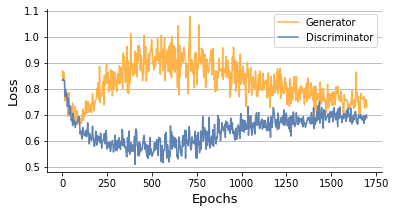

In [125]:
fig = plt.figure(figsize=(6,3))
ax1 = fig.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
rr = range(0,len(precision), 3)
short_precision = [precision[i] for i in rr]
short_g_loss = [g_loss[i] for i in rr]
short_d_loss = [d_loss[i] for i in rr]
#plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(rr, short_g_loss, label="Generator", color="#FFB248")
plt.plot(rr, short_d_loss, label="Discriminator", color="#5F84B4")
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Loss", fontsize=13)
plt.grid(axis="y")
plt.legend();
#plt.savefig('./drive/My Drive/Colab Notebooks/data/images/loss.svg');

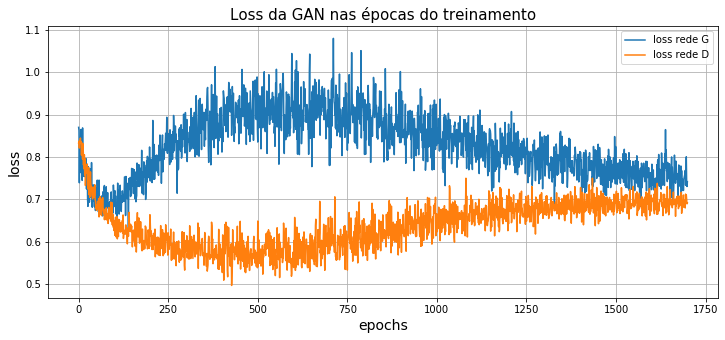

In [126]:
fig = plt.figure(figsize=(12,5))

plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(range(len(g_loss)), g_loss, label="loss rede G")
plt.plot(range(len(d_loss)), d_loss, label="loss rede D")
plt.xlabel("epochs", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.grid()
plt.legend();

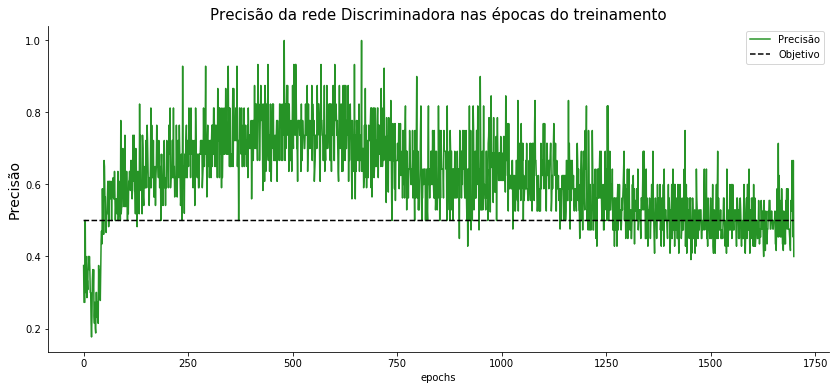

In [127]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot()
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
plt.title("Precisão da rede Discriminadora nas épocas do treinamento", fontsize=15)
plt.xlabel("epochs")
plt.ylabel("Precisão", fontsize=14)
plt.plot(range(len(precision)), precision, color="green", alpha=.85, label="Precisão");
plt.plot(range(len(precision)),np.ones(len(precision))*.5, color="black", ls="--", label="Objetivo");
plt.legend();

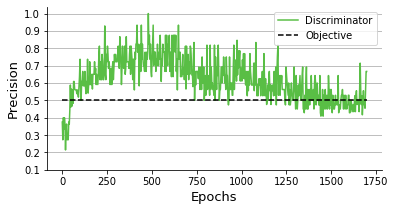

In [128]:
fig = plt.figure(figsize=(6,3))
ax1 = fig.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
rr = range(0,len(precision), 3)
short_precision = [precision[i] for i in rr]
#plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(rr, short_precision, color="#59BE45", alpha=1, label="Discriminator");
plt.plot(rr,np.ones(len(short_precision))*.5,
         color="black", ls="--", label="Objective");
plt.xlabel("Epochs", fontsize=13)
plt.ylabel("Precision", fontsize=13)
plt.yticks(np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]),
           np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]))
plt.grid(axis="y")
plt.legend();
#plt.savefig('./drive/My Drive/Colab Notebooks/data/images/precision.svg');

In [0]:
#gan.save("./drive/My Drive/Colab Notebooks/data/best_gan27012020.h5")

In [114]:
from tensorflow.keras.models import load_model

gan_save = load_model("./results/best_gan27012020.h5")
weights_save = gan_save.get_weights()
noise_input = 50
ep = 1700
#Gerador
optimizerG = SGD(lr=0.00015, momentum=0.92, decay=0.00015/ep)
#optimizerG = SGD(lr=0.00011, momentum=0.92)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/ep)
#optimizerD = SGD(lr=0.001, momentum=0.9)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()
gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()
gan.set_weights(weights_save)

Dimension del ruido de entrada:  50
Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_24 (Sequential)   (None, 9)                 11559     
_________________________________________________________________
sequential_25 (Sequential)   (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


(20, 2) (300, 2)


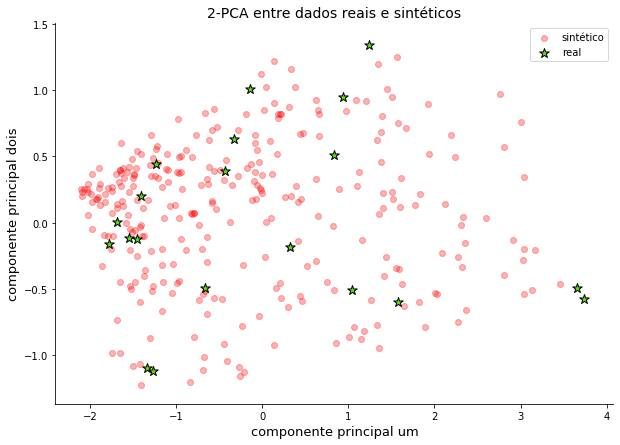

In [27]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
x_noise = G.predict(np.random.normal(0, 1, size=(300, noise_input)))
X_sint_pca = pca_real.transform(x_noise)
print(X_train_pca.shape, X_sint_pca.shape)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [129]:
m_precision = []
m_recall = []
m_f1score = []
m_accuracy = []
t_gi = time()
for i in range(5000):
    t_i = time()
    X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
    X_test = np.concatenate((X_train, X_sint))
    y_test = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_train.shape[0],1))))
    y_predict = D.predict_classes(X_test)
    m_precision.append(precision_score(y_test, y_predict))
    m_recall.append(recall_score(y_test, y_predict))
    m_f1score.append(f1_score(y_test, y_predict))
    m_accuracy.append(accuracy_score(y_test, y_predict))
    if i%500 == 0:
        t_f = time()
        print ('iteration:[%d/%d], time: %f' % (i, 5000, t_f-t_i))
t_gf = time()
print("global time: ", (t_gf-t_gi)/60, "[s]")

iteration:[0/5000], time: 0.011730
iteration:[500/5000], time: 0.008095
iteration:[1000/5000], time: 0.007998
iteration:[1500/5000], time: 0.008860
iteration:[2000/5000], time: 0.010083
iteration:[2500/5000], time: 0.008498
iteration:[3000/5000], time: 0.009019
iteration:[3500/5000], time: 0.009395
iteration:[4000/5000], time: 0.008354
iteration:[4500/5000], time: 0.008405
global time:  0.7489576220512391 [s]


In [130]:
def boxtplot_values(v):
    """
    return the values to plot a boxplot with ouliers
    """
    q25 = np.quantile(v, q=.25, interpolation="midpoint")
    q50 = np.quantile(v, q=.5, interpolation="midpoint")
    q75 = np.quantile(v, q=.75, interpolation="midpoint")
    lower = q25 - 1.5*(q75-q25)
    upper = q75 + 1.5*(q75-q25)
    #outliers
    outliers = v[(v<lower)|(v>upper)]
    
    return [lower, q25, q50, q75, upper], outliers

### Boxplot das métricas do Discriminador

In [131]:
[pl, pq1, pq2, pq3, pu], pouts = boxtplot_values(np.array(m_precision))
[rl, rq1, rq2, rq3, ru], routs = boxtplot_values(np.array(m_recall))
[fl, fq1, fq2, fq3, fu], fouts = boxtplot_values(np.array(m_f1score))
[al, aq1, aq2, aq3, au], aouts = boxtplot_values(np.array(m_accuracy))

In [132]:
cats = ["Accuray", "Precision", "F1-score"]
p = figure(tools="", background_fill_color="#ffffff", x_range=cats, toolbar_location=None,
          plot_height=250, plot_width=300,) # title="Discriminator metrics"


p.segment(cats, [aq3,pq3,fq3], cats, [au,pu,fu], line_color="black")
p.segment(cats, [al,pl,fl], cats, [aq1,pq1,fq1], line_color="black")
# boxes
p.vbar(cats, 0.4, [aq2,pq2,fq2], [aq3,pq3,fq3], fill_color="#E08E79", line_color="black")
p.vbar(cats, 0.4, [aq1,pq1,fq1], [aq2,pq2,fq2], fill_color="#3B8686", line_color="black")
# whiskers
p.rect(cats, [al,pl,fl], 0.2, 0.0001, line_color="black")
p.rect(cats, [au,pu,fu], 0.2, 0.0001, line_color="black")

p.circle([cats[0] for i in range(len(np.unique(aouts)))], np.unique(aouts),
         size=6, color="#F38630", fill_alpha=0.6)
p.circle([cats[1] for i in range(len(np.unique(pouts)))], np.unique(pouts),
         size=6, color="#F38630", fill_alpha=0.6)
p.circle([cats[2] for i in range(len(np.unique(fouts)))], np.unique(fouts),
         size=6, color="#F38630", fill_alpha=0.6)

p.legend.background_fill_alpha = 0.0
show(p)

/home/edwin/.local/lib/python3.6/site-packages/bokeh/models/plots.py:767: UserWarning: 
You are attempting to set `plot.legend.background_fill_alpha` on a plot that has zero legends added, this will have no effect.

Before legend properties can be set, you must add a Legend explicitly, or call a glyph method with a legend parameter set.

  warnings.warn(_LEGEND_EMPTY_WARNING % attr)


In [133]:
np.arange(0.2,1,0.05)

array([0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 ,
       0.75, 0.8 , 0.85, 0.9 , 0.95])

In [134]:
print("----------------------------")
print("---- accuracy metrics -----")
print("----------------------------")
print("mean accuracy: ", np.round(np.mean(m_accuracy),4))
print("median accuracy: ", np.round(np.median(m_accuracy),4))
print("std accuracy: ", np.round(np.std(m_accuracy),4))
print("----------------------------")
print("---- precision metrics -----")
print("----------------------------")
print("mean precision: ", np.round(np.mean(m_precision),4))
print("median precision: ", np.round(np.median(m_precision),4))
print("std precision: ", np.round(np.std(m_precision),4))
print("----------------------------")
print("---- recall metrics -----")
print("----------------------------")
print("mean recall: ", np.round(np.mean(m_recall),4))
print("median recall: ", np.round(np.median(m_recall),4))
print("std recall: ", np.round(np.std(m_recall),4))
print("----------------------------")
print("---- f1-score metrics -----")
print("----------------------------")
print("mean recall: ", np.round(np.mean(m_f1score),4))
print("median recall: ", np.round(np.median(m_f1score),4))
print("std recall: ", np.round(np.std(m_f1score),4))

----------------------------
---- accuracy metrics -----
----------------------------
mean accuracy:  0.5017
median accuracy:  0.5
std accuracy:  0.0555
----------------------------
---- precision metrics -----
----------------------------
mean precision:  0.5082
median precision:  0.5
std precision:  0.059
----------------------------
---- recall metrics -----
----------------------------
mean recall:  0.5
median recall:  0.5
std recall:  0.0
----------------------------
---- f1-score metrics -----
----------------------------
mean recall:  0.5024
median recall:  0.5
std recall:  0.0282


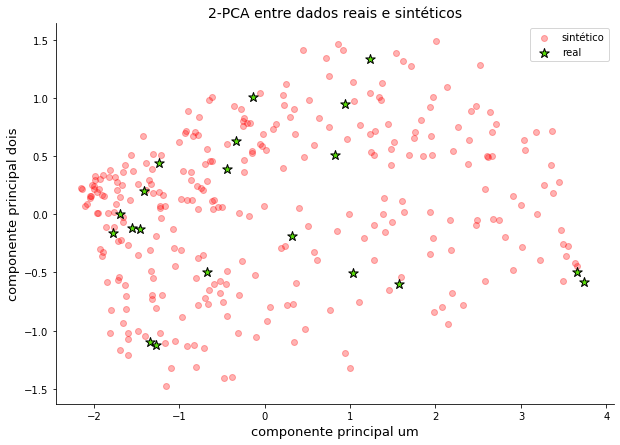

In [135]:
X_sint = G.predict(np.random.normal(0, 1, (300, noise_input)))
X_nov = np.concatenate((X_train[:14], X_sint))

fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

X_sint_pca = pca_real.transform(X_sint)

plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [138]:
def best_sample(generator, n_synt, n_samples, noise_input):
    """
    return the best sample of the list the n_samples
    generated by the generator.
    """
    cv_dict = {}
    best_score = np.inf
    best_idx = np.inf
    for i in range(n_samples):
        x_pred = generator.predict(np.random.normal(0, 1, (n_synt, noise_input)))
        x_trans = obj.inverse_transform(x_pred)
        #coefficient of variation
        cv = np.median(np.std(x_trans, axis=1)/np.mean(x_trans, axis=1))
        if cv < best_score:
            best_score = cv
            best_idx = i
        cv_dict[i] = (cv, x_pred)
    return cv_dict, best_idx

In [139]:
t_i = time()
dt_cv, best_idx = best_sample(G, 300, 5000, noise_input)
t_f = time()
print("tempo de execuçฺão: ", (t_f-t_i), "[s]")
print(dt_cv[best_idx][0], best_idx)

tempo de execuçฺão:  62.555264711380005 [s]
0.1401170050001582 1830


In [140]:
c_v = []
for i in dt_cv.keys():
    c_v.append(dt_cv[i][0])

0.17067265947867105


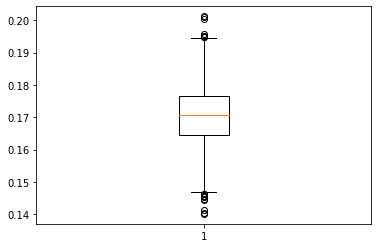

In [141]:
print(np.median(c_v))
plt.boxplot(c_v,);

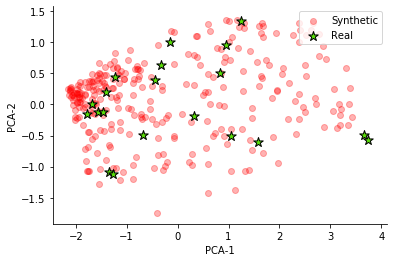

In [142]:
fig2 = plt.figure(figsize=(6,4))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

X_sint_pca = pca_real.transform(dt_cv[best_idx][1])

#plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="Synthetic", alpha=.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="Real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend(loc="upper right");
#plt.savefig('./drive/My Drive/Colab Notebooks/data/images/new_data.svg');

In [143]:
#ENTRENANDO EL CLASIFICADOR SOLO CON LOS GENES DE REFERENCIA

from sklearn.svm import OneClassSVM
#nu=0.138

X_normal = X_train
clf = OneClassSVM(kernel="rbf", nu=0.0112, gamma=1/9).fit(X_normal[:14]) #0.0138

print("train accuracy: ", accuracy_score(np.ones(14),clf.predict(X_normal[:14])))
print("test accuracy in the RG: ", accuracy_score(np.ones(6),clf.predict(X_normal[14:]) ))
print("accuray em todos os genes de referência: ", accuracy_score(np.ones(X_normal.shape[0]),clf.predict(X_normal)))
print("------------------------------------------------------")

predict_cand = clf.predict(X_cand)

cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
cand.shape, no_cand.shape

train accuracy:  0.6428571428571429
test accuracy in the RG:  0.6666666666666666
accuray em todos os genes de referência:  0.65
------------------------------------------------------


((680, 9), (3488, 9))

In [144]:
X_nov = np.concatenate((X_train[:14], dt_cv[best_idx][1]))
X_nov.shape

(314, 9)

train accuracy in the augmented data:  0.9777070063694268
train accuracy in the RG:  0.7857142857142857
test accuracy in the RG:  0.8571428571428571
accuray em todos os genes de referência:  0.8
------------------------------------------------------
train accuracy in the augmented data:  0.9777070063694268
train accuracy in the RG:  0.7857142857142857
test accuracy in the RG:  0.8571428571428571
accuray em todos os genes de referência:  0.8
accuracy de solo datos sintéticos:  0.9643333333333334


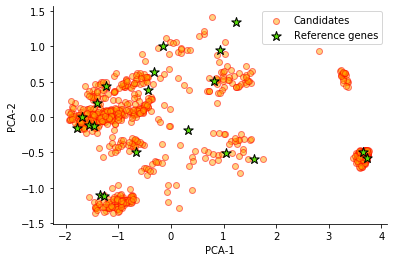

In [147]:

from sklearn.svm import OneClassSVM
#nu=0.138
clf = OneClassSVM(kernel="rbf", nu=0.001, gamma="auto").fit(X_nov) #0.0138

print("train accuracy in the augmented data: ", accuracy_score(np.ones(X_nov.shape[0]), clf.predict(X_nov)))
print("train accuracy in the RG: ", accuracy_score(np.ones(14),clf.predict(X_train[:14]) ))
print("test accuracy in the RG: ", accuracy_score(np.ones(7),clf.predict(X_train[13:]) ))
print("accuray em todos os genes de referência: ", accuracy_score(np.ones(X_train.shape[0]),clf.predict(X_train)))
print("------------------------------------------------------")

print("train accuracy in the augmented data: ", recall_score(np.ones(X_nov.shape[0]), clf.predict(X_nov)))
print("train accuracy in the RG: ", recall_score(np.ones(14),clf.predict(X_train[:14]) ))
print("test accuracy in the RG: ", recall_score(np.ones(7),clf.predict(X_train[13:])))
print("accuray em todos os genes de referência: ", recall_score(np.ones(X_train.shape[0]),clf.predict(X_train)))

print("accuracy de solo datos sintéticos: ", recall_score(np.ones(3000),
                                                          clf.predict(G.predict(np.random.normal(0, 1, (3000, noise_input))))))
predict_cand = clf.predict(X_cand)

cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
cand.shape, no_cand.shape
X_nov_pca = pca_real.transform(X_nov)
X_cand_pca = pca_real.transform(cand)
X_nocand_pca = pca_real.transform(no_cand)

fig2 = plt.figure(figsize=(6,4))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
#plt.scatter(X_nocand_pca[:, 0], X_nocand_pca[:, 1], c='blue', s=30, edgecolors='k');
plt.scatter(X_cand_pca[:, 0], X_cand_pca[:, 1], c='orange', alpha=.5, edgecolors="red",
            label="Candidates");
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="Reference genes", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();
#plt.savefig('./drive/My Drive/Colab Notebooks/data/images/candidates.svg');

### One-class classification with SVM

In [148]:
from sklearn.svm import OneClassSVM
#nu=0.138
clf = OneClassSVM(kernel="rbf", nu=0.001, gamma="auto").fit(X_nov) #0.0138

print("score no treinamento: ", np.mean(clf.predict(X_nov)==1))
print("score nos genes de referência de treinamento: ", np.mean(clf.predict(X_train[:14]) == 1))
print("score nos genes de referência no utilizados pro treinamento: ",
     np.mean(clf.predict(X_train[14:]) == 1))
print("score em todos os genes de referência: ", np.mean(clf.predict(X_train)==1))

score no treinamento:  0.9777070063694268
score nos genes de referência de treinamento:  0.7857142857142857
score nos genes de referência no utilizados pro treinamento:  0.8333333333333334
score em todos os genes de referência:  0.8


In [149]:
#gan.save("./data/best_gan.h5")

In [150]:
predict_cand = clf.predict(X_cand)

In [151]:
cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
cand.shape, no_cand.shape

((878, 9), (3290, 9))

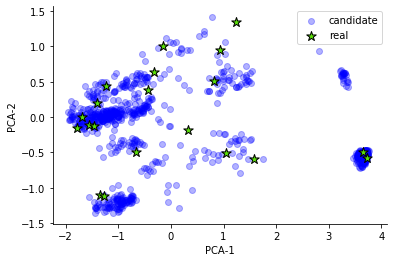

In [152]:
fig2 = plt.figure(figsize=(6,4))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
#plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")

X_sint_pca = pca_real.transform(X_sint)
X_cand_pca = pca_real.transform(cand)
X_nocand = pca_real.transform(no_cand)

plt.scatter(X_cand_pca[:,0], X_cand_pca[:,1], color="blue", label="candidate",alpha=.3,)
#plt.scatter(X_nov_pca[:, 0], X_nov_pca[:, 1], c='red', s=30, alpha=.3, label="synthetic");
#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="black", label="no_cand",alpha=0.1)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1, marker="*", edgecolors="black", s=100)
#plt.grid()
plt.legend();

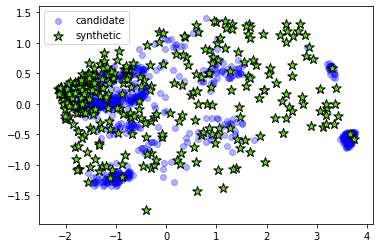

In [153]:
plt.scatter(X_cand_pca[:,0], X_cand_pca[:,1], color="blue", label="candidate",alpha=.3,)
plt.scatter(X_nov_pca[:, 0], X_nov_pca[:, 1], c='#5ADE09', s=100, alpha=1, marker="*",label="synthetic", edgecolors="black");
#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="black", label="no_cand",alpha=0.1)
#plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="#5ADE09", label="real", alpha=1, marker="*", edgecolors="black", s=100)
plt.legend();

In [154]:
print("redução do ", (1 - cand.shape[0]/X_cand.shape[0])*100,"% no processo de escolha de candidatos")

redução do  78.93474088291747 % no processo de escolha de candidatos


In [155]:
obj_rg = open("./data/RG_artigoMoose.txt")
rg_moose = [g for g in obj_rg.read().splitlines()]
print("Genes candidatos do artigo moose:", len(rg_moose))
print(rg_moose)

Genes candidatos do artigo moose: 27
['dnaG', 'dtpB', 'ftsX', 'ftsY', 'glyY', 'gyrB', 'lhr', 'mutM', 'mutY', 'ndk', 'nfuA', 'pnp', 'rbbA', 'rhsB', 'rpsU', 'rrsE', 'rrsG', 'secB', 'spoT', 'tfaR', 'thrW', 'valS', 'yedJ', 'ynaE', 'yphG', 'zntA', 'zupT']


In [156]:
for i in rg:
    if i in rg_moose:
        print(i)

gyrB
dnaG


In [157]:
print(cand.loc[rg_moose].dropna().shape[0])
cand.loc[rg_moose].dropna()

11


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
ftsX,0.695567,0.657817,0.714709,0.703786,0.689007,0.679817,0.627045,0.635738,0.648512
ftsY,0.734632,0.733591,0.794660,-0.650803,0.759634,0.736101,0.682666,0.613599,0.705083
glyY,0.325490,0.336130,0.440474,0.471258,0.417251,0.299939,0.240026,-0.008847,0.235020
mutY,0.708679,0.703653,0.720573,0.741906,-0.724643,0.700263,0.635943,0.599778,0.676169
ndk,-0.281602,-0.242767,-0.128360,-0.089681,-0.134461,-0.211738,-0.192042,1.009335,-0.286640
nfuA,0.905821,0.899027,0.987680,0.991985,0.981116,0.875800,0.849890,0.711463,0.841314
rrsE,0.587656,0.604759,0.693686,0.763962,0.745445,0.692236,0.564757,0.333634,0.588330
rrsG,-0.340691,-0.307542,-0.218399,-0.166913,-0.192341,-0.278790,-0.419332,0.789914,-0.380720
spoT,0.884382,0.884552,0.940746,0.896704,0.886937,0.848056,0.782912,0.707923,0.829242


In [158]:
obj_edi = open("./data/RG_artigoEdian.txt")
rg_edi = [g for g in obj_edi.read().splitlines()]
print("Genes candidatos do artigo edian:", len(rg_edi))
print(rg_edi)

Genes candidatos do artigo edian: 17
['bamD', 'efp', 'gatB', 'gatD', 'hfq', 'nusA', 'polA', 'prc', 'prfB', 'ptsN', 'rimP', 'rplP', 'rpsC', 'rpsO', 'rpsU', 'slyD', 'ychF']


In [159]:
cand.loc[rg_edi].dropna()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
bamD,0.900921,0.888817,0.967560,0.940572,0.945553,0.844037,0.738203,-0.895271,0.722070
gatD,0.797513,0.779422,0.864410,0.888021,0.879034,0.811774,0.696794,0.558069,0.723031
ptsN,0.788705,0.766796,0.808711,0.881338,0.850952,0.785160,0.660781,0.588654,0.714060


## Isolation Forest

In [0]:
from sklearn.ensemble import IsolationForest

clf2 = IsolationForest(n_estimators=100, contamination=0, random_state=False,
                      behaviour="new", n_jobs=2, warm_start=True)
clf2.fit(X_nov)

print("score no treinamento: ", np.mean(clf2.predict(X_nov)==1))
print("score nos genes de referência de treinamento: ", np.mean(clf2.predict(X_train[:14]) == 1))
print("score nos genes de referência no utilizados pro treinamento: ",
     np.mean(clf2.predict(X_train[14:]) == 1))
print("score em todos os genes de referência: ", np.mean(clf2.predict(X_train)==1))

score no treinamento:  1.0
score nos genes de referência de treinamento:  1.0
score nos genes de referência no utilizados pro treinamento:  1.0
score em todos os genes de referência:  1.0


In [0]:
predict_cand = clf2.predict(X_cand)
cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
print(cand.shape, no_cand.shape)
print("redução do ", (1 - cand.shape[0]/datos.shape[0])*100,"% no processo de escolha de candidatos")

(2956, 9) (1229, 9)
redução do  29.70273483947682 % no processo de escolha de candidatos


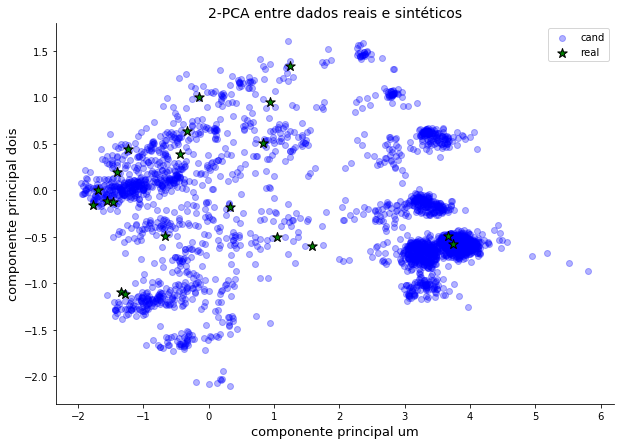

In [0]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)

X_sint_pca = pca_real.transform(X_sint)
X_cand_pca = pca_real.transform(cand)
X_nocand = pca_real.transform(no_cand)

#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=.3)
plt.scatter(X_cand_pca[:,0], X_cand_pca[:,1], color="blue", label="cand",alpha=.3)
#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=0.1)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [0]:
print(cand.loc[rg_moose].dropna().shape[0])
cand.loc[rg_moose].dropna()

23


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
dtpB,-0.790432,-0.815620,0.621418,0.649137,0.668417,0.679104,0.613943,0.632987,0.645587
ftsX,0.695567,0.657817,0.714709,0.703786,0.689007,0.679817,0.627045,0.635738,0.648512
ftsY,0.734632,0.733591,0.794660,-0.650803,0.759634,0.736101,0.682666,0.613599,0.705083
glyY,0.325490,0.336130,0.440474,0.471258,0.417251,0.299939,0.240026,-0.008847,0.235020
lhr,-1.035834,-1.041366,-1.066099,0.405957,-1.071559,-1.060662,-1.104705,-1.030697,-1.028057
mutY,0.708679,0.703653,0.720573,0.741906,-0.724643,0.700263,0.635943,0.599778,0.676169
ndk,-0.281602,-0.242767,-0.128360,-0.089681,-0.134461,-0.211738,-0.192042,1.009335,-0.286640
nfuA,0.905821,0.899027,0.987680,0.991985,0.981116,0.875800,0.849890,0.711463,0.841314
pnp,1.012026,1.028689,-0.288030,-0.259168,-0.287101,-0.396191,0.954108,0.772673,0.990685


In [0]:
print(cand.loc[rg_edi].dropna().shape[0])
cand.loc[rg_edi].dropna()

12


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
bamD,0.900921,0.888817,0.967560,0.940572,0.945553,0.844037,0.738203,-0.895271,0.722070
efp,0.883929,0.893426,0.986886,0.953313,0.964894,0.900637,-0.666888,0.658397,0.797629
gatD,0.797513,0.779422,0.864410,0.888021,0.879034,0.811774,0.696794,0.558069,0.723031
polA,0.657993,0.637631,0.712010,0.686595,0.690273,-0.891506,0.583032,-0.902868,0.601666
prc,0.701789,0.687073,0.768016,0.716171,0.720595,0.659306,-0.893690,-0.953165,0.564771
prfB,1.041426,1.043074,-0.282184,1.046805,1.046628,0.958977,0.845067,0.715257,0.881996
ptsN,0.788705,0.766796,0.808711,0.881338,0.850952,0.785160,0.660781,0.588654,0.714060
rimP,-0.661678,0.776155,0.880130,0.877383,0.870669,0.813908,0.679395,0.567525,-0.761204
rpsO,0.938523,0.932230,-0.408265,-0.417435,-0.436328,0.963185,0.966226,0.727576,0.862091


## LocalOutlierFactor

In [0]:
from sklearn.neighbors import LocalOutlierFactor

clf3 = LocalOutlierFactor(n_neighbors=2, contamination=0.00001, novelty=True,)
clf3.fit(X_nov)

print("score no treinamento: ", np.mean(clf3.predict(X_nov)==1))
print("score nos genes de referência de treinamento: ", np.mean(clf3.predict(X_train[:14]) == 1))
print("score nos genes de referência no utilizados pro treinamento: ",
     np.mean(clf3.predict(X_train[14:]) == 1))
print("score em todos os genes de referência: ", np.mean(clf3.predict(X_train)==1))

score no treinamento:  1.0
score nos genes de referência de treinamento:  1.0
score nos genes de referência no utilizados pro treinamento:  1.0
score em todos os genes de referência:  1.0


In [0]:
predict_cand = clf3.predict(X_cand)
cand = X_cand.loc[predict_cand == 1]
no_cand = X_cand.loc[predict_cand == -1]
print(cand.shape, no_cand.shape)
print("redução do ", (1 - cand.shape[0]/datos.shape[0])*100,"% no processo de escolha de candidatos")

(3344, 9) (841, 9)
redução do  20.4756242568371 % no processo de escolha de candidatos


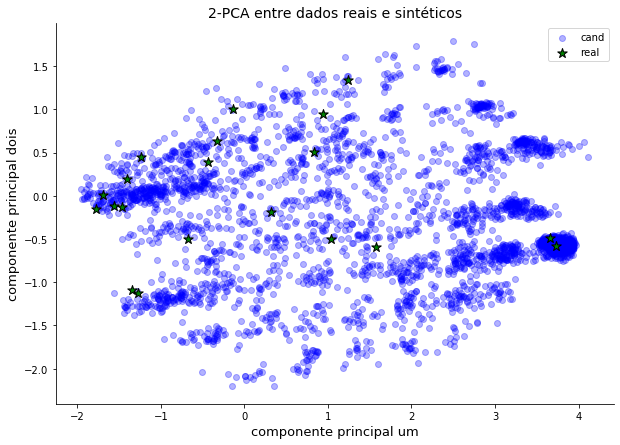

In [0]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)

X_sint_pca = pca_real.transform(X_sint)
X_cand_pca = pca_real.transform(cand)
X_nocand = pca_real.transform(no_cand)

#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=.3)
plt.scatter(X_cand_pca[:,0], X_cand_pca[:,1], color="blue", label="cand",alpha=.3)
#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=0.1)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [0]:
print(cand.loc[rg_moose].dropna().shape[0])
print(cand.loc[rg_edi].dropna().shape[0])

21
17


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
